# World Data League 2022


## 🎯 Challenge: Predict Waste Production for its Reduction

#### The goal of this challenge is to help identify trends in waste production and help to create insights into how to reduce waste and optimize its collection.





## 👥 Authors

**Team: Moons of Jupyter** <br>

- Ajit Gupta
- Cristian Castro Alvarez
- Gabrijela Juresic
- Tejas Choudekar

## 💻 Development
Start coding here! 🐱‍🏍


In [1]:
# Importing necessary Libraries

import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Libraries from fbprophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from chart_studio.plotly import plot, iplot

from fbprophet.diagnostics import cross_validation

from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_cross_validation_metric

# LIbrary form sklearn
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

from statsmodels.tsa.seasonal import seasonal_decompose



In [2]:
# importng the waste collection dataset

data = pd.read_csv("C:/Users/Shanks/Desktop/WDL/Stage 1/Waste_Collection___Diversion_Report__daily_.csv")
data['Report Date'] = pd.to_datetime(data['Report Date'])
data['Report Date'].apply(lambda x: x.strftime('%Y-%m-%d'))

0         2020-12-08
1         2020-12-08
2         2020-12-03
3         2020-12-07
4         2020-12-07
             ...    
740868    2008-04-09
740869    2015-12-01
740870    2007-04-25
740871    2008-04-09
740872    2008-04-08
Name: Report Date, Length: 740873, dtype: object

### 1. Exploratory Data Analysis

In [3]:
missing = data[data["Load Weight"].isnull()]
print("Missing Percentage {:.2f}".format(100*len(missing)/len(data)))

Missing Percentage 9.76


Missing Load Weight are 9.76 %,Further analysis needed i.e in whihc category we are missing values.

81.34435373688787

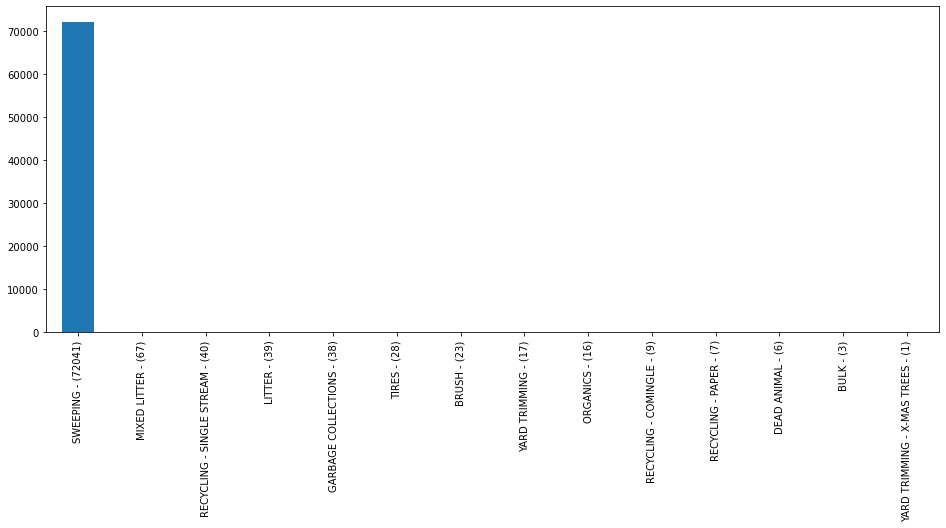

In [4]:
# Analysing which load type is contributing to missing values
plt.figure(figsize = (16,6))
missing_load_type = missing["Load Type"].value_counts()
ax = missing_load_type.plot(kind = 'bar')
labels = []
for i, label in enumerate(missing_load_type.index):
    labels.append('{} - ({})'.format(label, missing_load_type[label]))
ax.set_xticklabels(labels);

load_type_counts = data["Load Type"].value_counts()
100*missing_load_type["SWEEPING"]/load_type_counts["SWEEPING"]

Most of the missing values of Load Weight in data are from $SWEEPING$, ~81% of data are missing from SWEEPING. Its more likely people incharge of filling the data for SWEEPING dont fill the value of that day and left it blank.

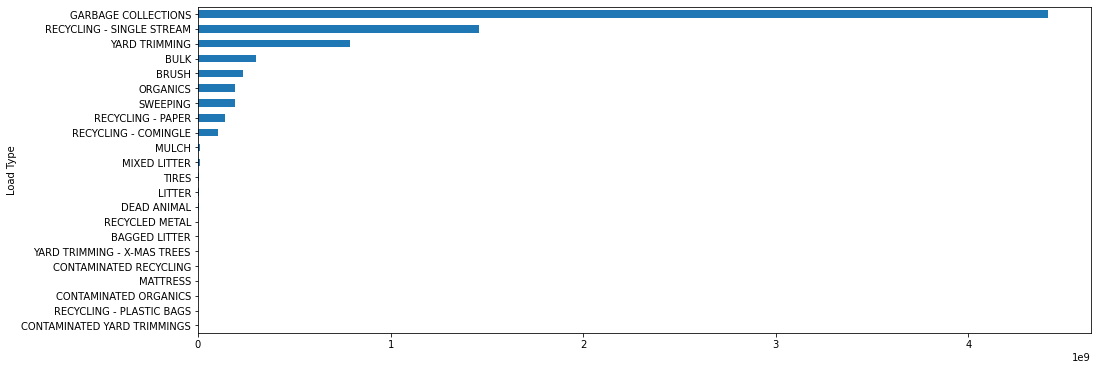

In [5]:
# Distribution of Load Weight in Load Type

plt.figure(figsize = (16,6))
dist = data.groupby('Load Type')['Load Weight'].sum().sort_values(ascending=True)
dist.plot(kind='barh');


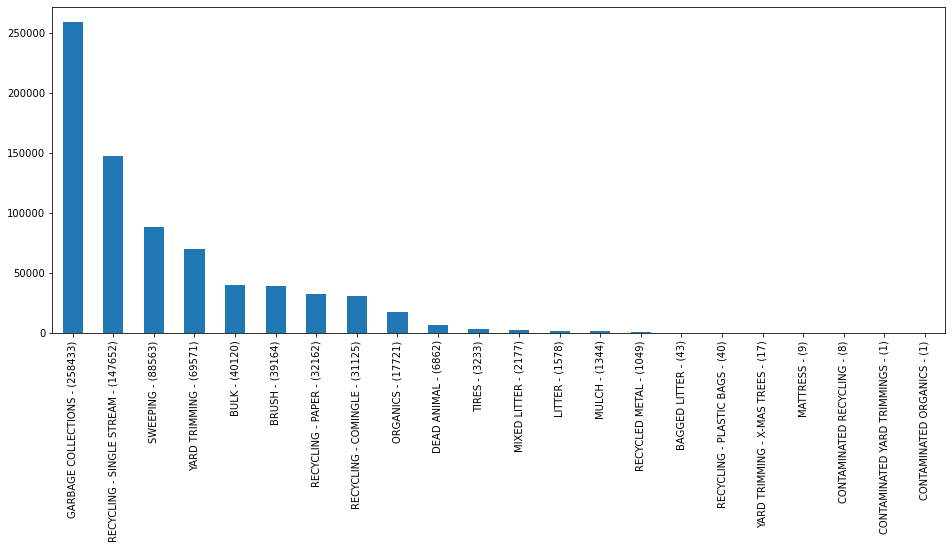

In [6]:
# Distribution of value counts in Load Type

plt.figure(figsize = (16,6))
load_type_counts = data["Load Type"].value_counts()
ax = load_type_counts.plot(kind = 'bar')
labels = []
for i, label in enumerate(load_type_counts.index):
    labels.append('{} - ({})'.format(label, load_type_counts[label]))
ax.set_xticklabels(labels);

As per Austin Texas website https://www.austintexas.gov/myschedule
* Garbage is collected every Week
* Recycling Materials are collected every Two Week
* Trash are collected every Week.

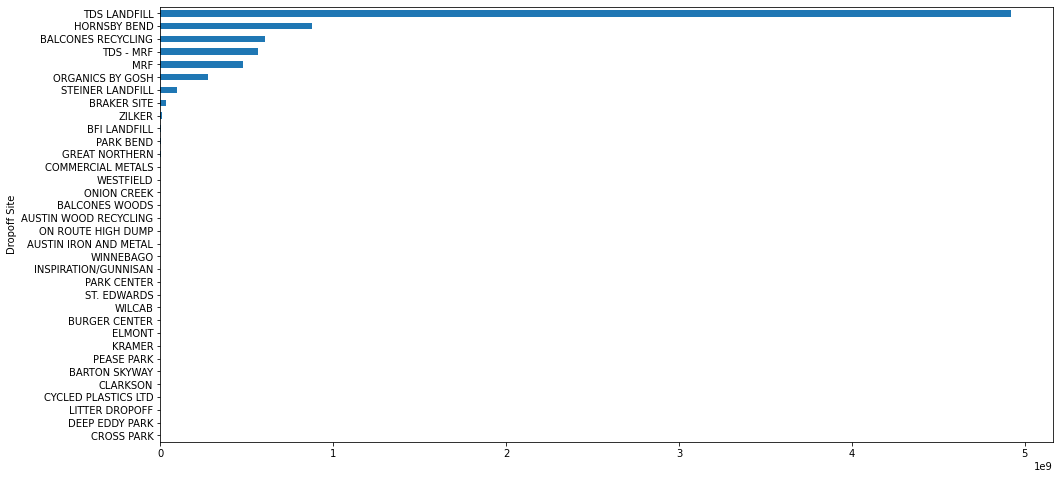

In [7]:
# Distribution of Load Weight in Dropoff Site

plt.figure(figsize = (16,8))
dist = data.groupby('Dropoff Site')['Load Weight'].sum().sort_values(ascending=True)
dist.plot(kind='barh');


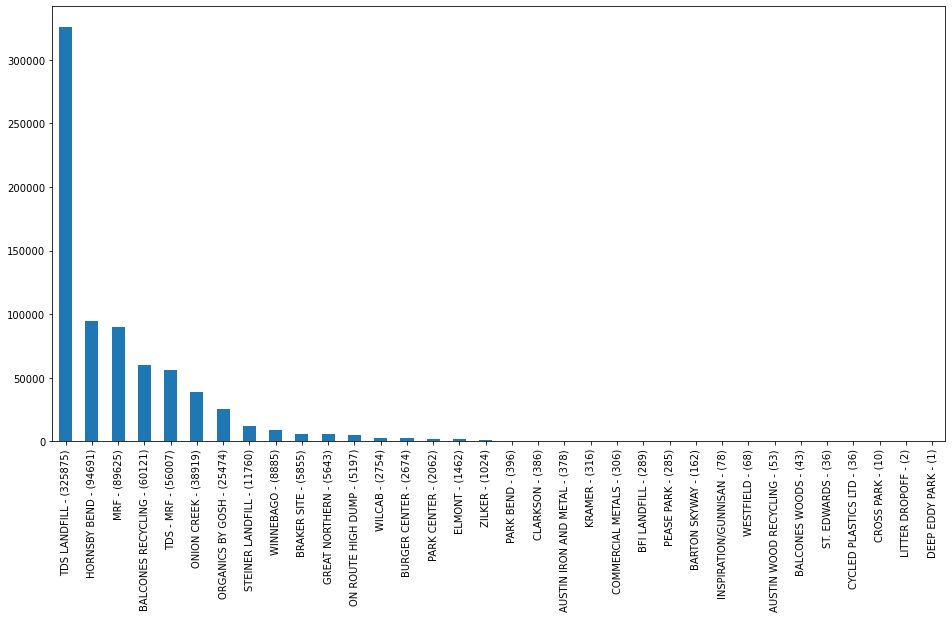

In [8]:
# Distribution of counts in Dropoff Site 

plt.figure(figsize = (16,8))
dropoff_site_counts = data["Dropoff Site"].value_counts()
ax = dropoff_site_counts.plot(kind = 'bar')
labels = []
for i, label in enumerate(dropoff_site_counts.index):
    labels.append('{} - ({})'.format(label, dropoff_site_counts[label]))
ax.set_xticklabels(labels);

* TDS Landfill is primary Dropoff Site of waste in Texas Austin
* Hornsby Bend is Bioslid Management Plant
* We find TDS-MRF and MRF is same and its a Materail Recovery Facility
* Balcones Recycling is used to Brush and Yard Trimming

TDS - Texas Disposal System, 
MRF - Material Recovery Facility

### 2. Analysis of different Load Types

C:\Users\Shanks\AppData\Local\Temp\ipykernel_4520\831826136.py:12: UserWarning: Attempting to set identical left == right == 737090.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xmin = min(load_weight.index),xmax = max(load_weight.index))
C:\Users\Shanks\AppData\Local\Temp\ipykernel_4520\831826136.py:12: UserWarning: Attempting to set identical left == right == 737941.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xmin = min(load_weight.index),xmax = max(load_weight.index))


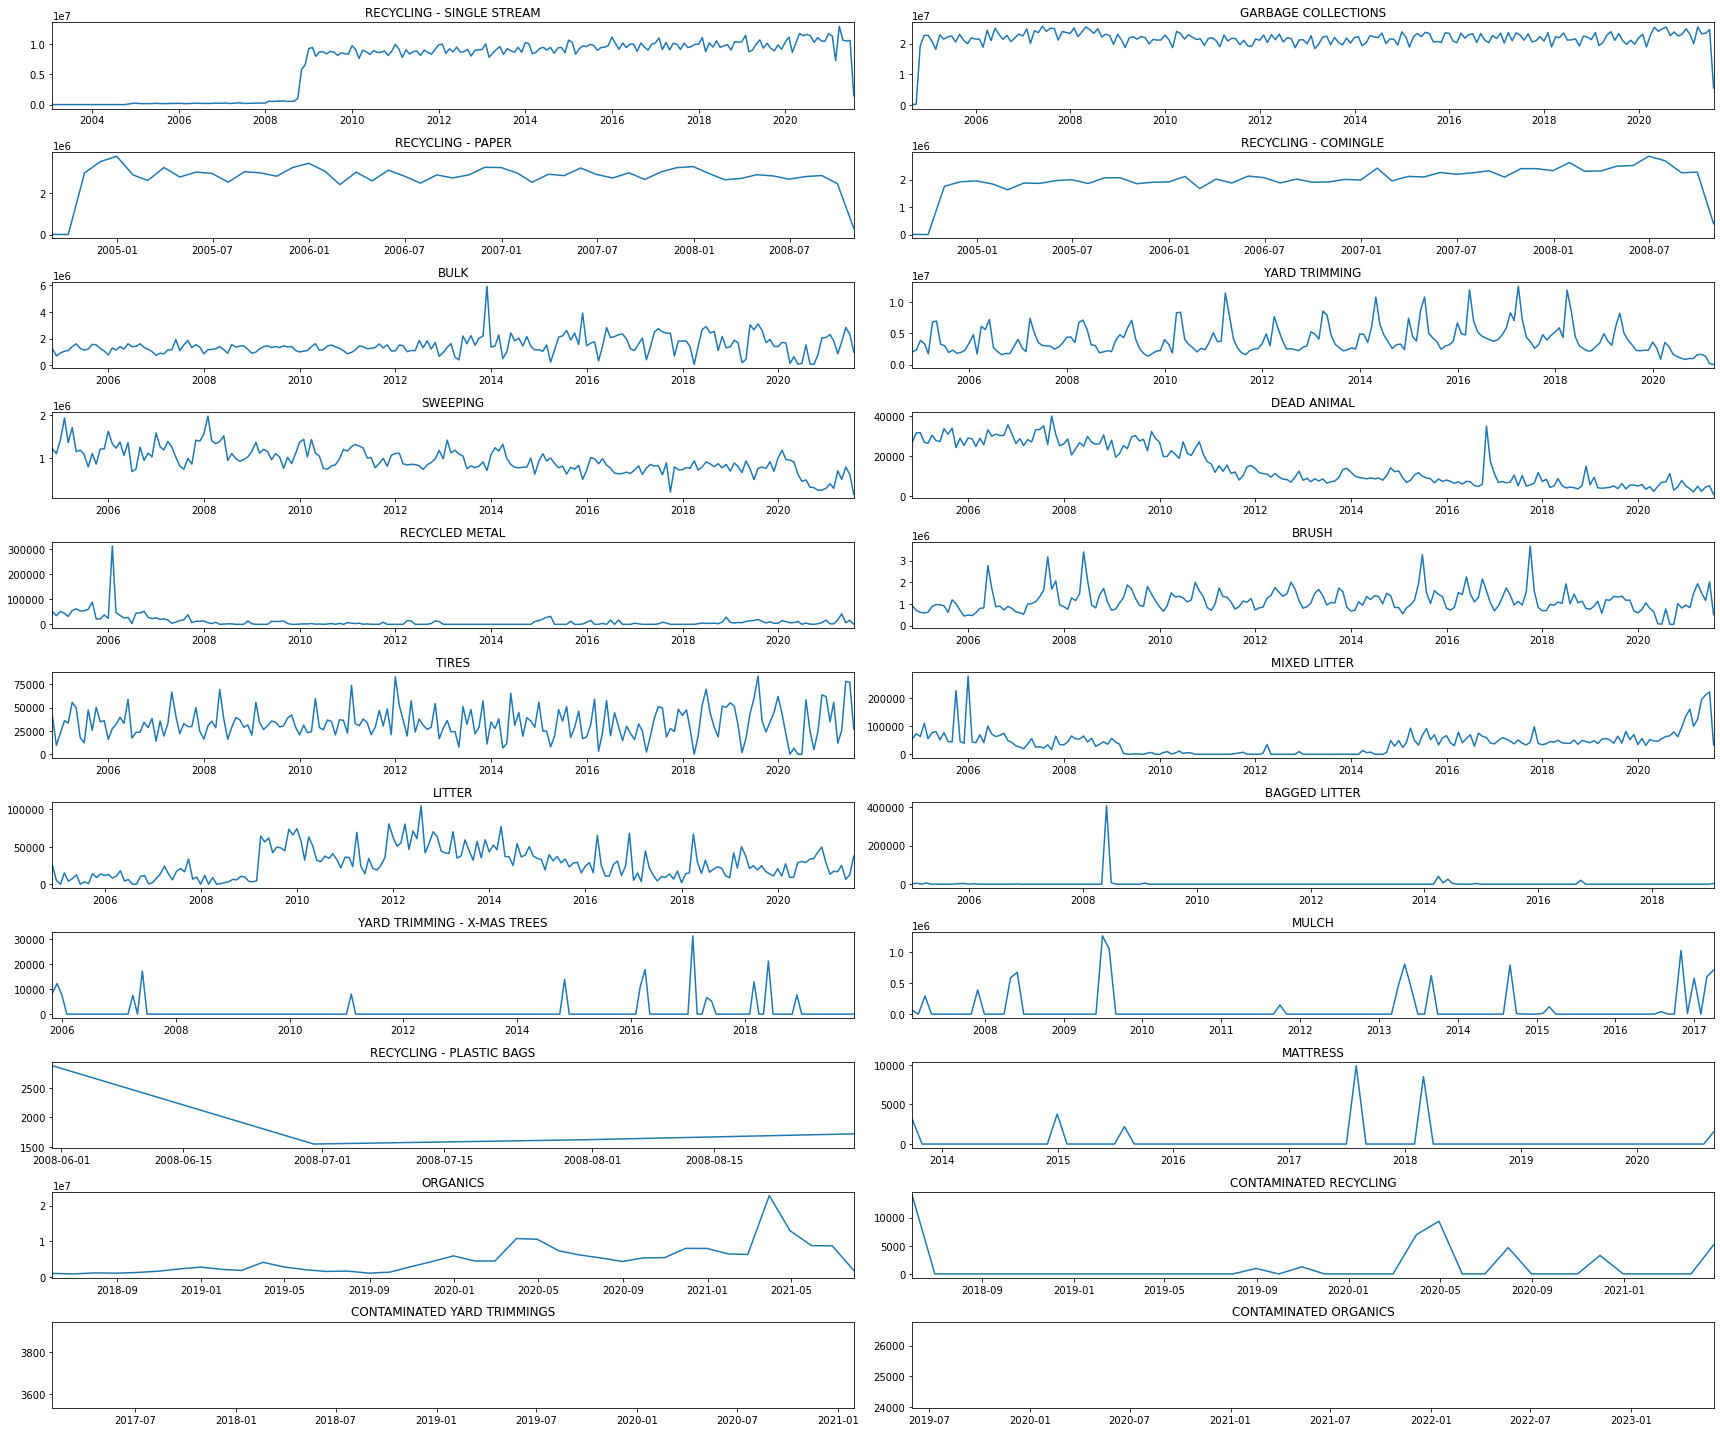

In [9]:
data_time = data.sort_values('Report Date',ascending=True)
data_time.index = data_time['Report Date']
data_time.drop('Report Date',axis=1,inplace=True)

load_types = data_time["Load Type"].unique()

fig = plt.figure(figsize = (24,20))
for i,type in enumerate(load_types):
    load_weight = data_time[data_time['Load Type'] == type]['Load Weight'].resample('M').sum()
    ax = fig.add_subplot(11,2,i+1)
    plt.plot(load_weight.index,load_weight.values)
    ax.set_xlim(xmin = min(load_weight.index),xmax = max(load_weight.index))
    plt.title(type)

fig.tight_layout() 
    



- Recycling-Single Stream starts from 2009 and Recycling-Papers and Recycling-Comingle ends in 2009, it seems like they    merge these two to Single Stream.
- Yard Treaming, Bulk indicate some king of seasionality 

Major Load types for further analysis:
- *GARBAGE COLLECTIONS*
- *BULK*
- *RECYCLING SINGLE-STREAM*
- *SWEEPING*
- *TIRES*
- *YARD-TRIMMING*
- *BRUSH*

From the above graphs we noticed some seasonality in load types mainly in
- Garbage Collections,
- Yard Trimming and 
- Recycling-Single-Stream

#### 2.1 Feature Engineering and Dataset Creations for Time Series Analysis

In [10]:
waste_data = data.copy(deep=True)
waste_data = waste_data.sort_values('Report Date')
waste_data = waste_data.groupby(['Report Date','Load Type']).sum()
waste_data = waste_data.reset_index()
waste_data = waste_data.drop('Load ID',axis=1)
waste = waste_data.pivot_table(index="Report Date", columns="Load Type", values="Load Weight", aggfunc=np.sum).reset_index()



 - Recycling-Single Stream starts from 2009 and Recycling-Papers and Recycling-Comingle ends in 2009 (we excluded these for our analysis), Recycling-Metal and Recycling-Plastic Bags have data till 2021, we merged these to form RECYCLING load type.
 
 - Brush, organics, yard-trimming, yard-trimming-x-mas-tree and dead animals comes under COMPOSTABLE, we created a sepearte Load Type for that.
 
 - Bulk and Tires are reusable materials, we created a Load Type REUSABLE for that.

In [11]:
waste['RECYCLING'] = waste.fillna(0)['RECYCLING - SINGLE STREAM'] + waste.fillna(0)['RECYCLED METAL'] + waste.fillna(0)['RECYCLING - PLASTIC BAGS']

waste['COMPOSTABLE'] = waste.fillna(0)['BRUSH'] + waste.fillna(0)['ORGANICS'] + waste.fillna(0)['YARD TRIMMING'] + waste.fillna(0)['YARD TRIMMING - X-MAS TREES'] + waste.fillna(0)['DEAD ANIMAL']

waste['REUSABLE'] = waste.fillna(0)['TIRES'] + waste.fillna(0)['BULK']

In [12]:
waste.drop(['BAGGED LITTER',
             'BRUSH',
             'CONTAMINATED ORGANICS',
             'CONTAMINATED RECYCLING',
             'CONTAMINATED YARD TRIMMINGS',
             'MATTRESS',
             'MULCH',
             'ORGANICS',
             'RECYCLED METAL',
             'RECYCLING - COMINGLE',
             'RECYCLING - PAPER',
             'RECYCLING - PLASTIC BAGS',
             'RECYCLING - SINGLE STREAM',
             'YARD TRIMMING',
             'YARD TRIMMING - X-MAS TREES',
             'DEAD ANIMAL',
             'TIRES',
             'BULK',
             'LITTER',
             'MIXED LITTER'],
             axis = 1,
             inplace=True)
waste.head()

Load Type Report Date  GARBAGE COLLECTIONS  SWEEPING  RECYCLING  COMPOSTABLE  \
0          2003-01-13                  NaN       NaN    20170.0          0.0   
1          2004-08-25             139140.0       NaN        0.0          0.0   
2          2004-08-26              61480.0       NaN        0.0          0.0   
3          2004-08-30                  NaN       NaN        0.0          0.0   
4          2004-09-28             120740.0       NaN        0.0          0.0   

Load Type  REUSABLE  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

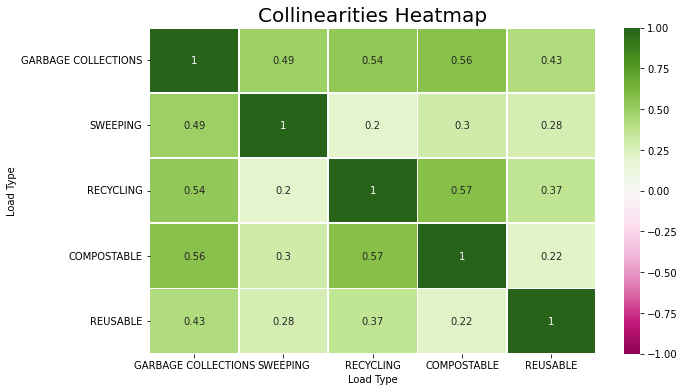

In [13]:
cor = waste.corr()

fig,ax  = plt.subplots(1,1,figsize = (10,6))
sns.heatmap(data= cor,vmin=-1,vmax=1,cmap="PiYG",linewidths=0.8,ax=ax,annot=True)
ax.set_title('Collinearities Heatmap', fontsize=20)

plt.show()



Correlation Heatmap does not shows any strong correlations in load types.This indicate we can create sepearate models for these Load Types.

### 3 Time Series Analysis and Model of GARBAGE COLLECTION Using Fbprophet 

#### 3.1 Analysis of GARBAGE COLLECTION

In [14]:
garbage = waste[["Report Date","GARBAGE COLLECTIONS"]]
garbage.fillna(0,inplace=True)
garbage = garbage.rename(columns={'Report Date':'ds','GARBAGE COLLECTIONS':'y'})

garbage_w = garbage.groupby(pd.Grouper(key='ds', freq='1W')).sum()
garbage_w.reset_index(inplace = True)

garbage_2w = garbage.groupby(pd.Grouper(key='ds', freq='2W')).sum()
garbage_2w.reset_index(inplace = True)

garbage_m = garbage.groupby(pd.Grouper(key='ds', freq='1M')).sum()
garbage_m.reset_index(inplace = True)

                        

C:\Users\Shanks\anaconda3\envs\work\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


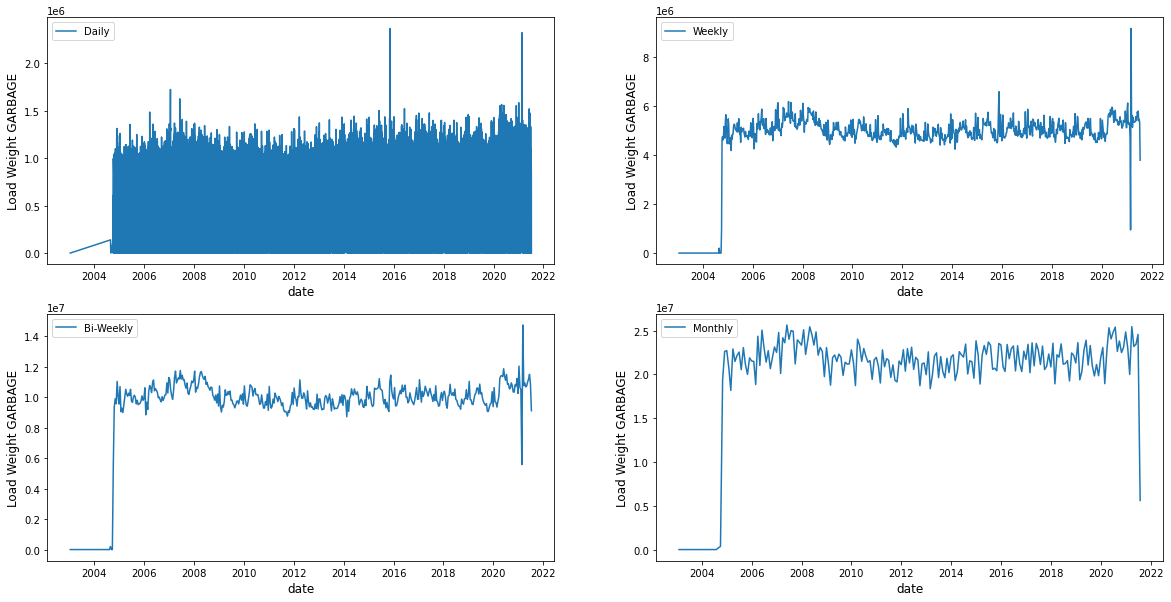

In [15]:
fig,axes = plt.subplots(2,2,figsize = (20,10))

legends = [['Daily','Weekly'],['Bi-Weekly','Monthly']]

axes[0,0].plot(garbage['ds'],garbage['y'])

axes[0,1].plot(garbage_w['ds'],garbage_w['y'])

axes[1,0].plot(garbage_2w['ds'],garbage_2w['y'])

axes[1,1].plot(garbage_m['ds'],garbage_m['y'])

for i in range(2):
    for j in range(2):
        axes[i,j].legend([legends[i][j]]);
        [l.set_fontsize(10) for l in axes[i,j].xaxis.get_ticklabels()]
        [l.set_fontsize(10) for l in axes[i,j].yaxis.get_ticklabels()]
        axes[i,j].set_xlabel('date', fontsize=12)
        axes[i,j].set_ylabel('Load Weight GARBAGE', fontsize=12);


We do some seasonality in Weekly, Bi-Weekly and Monthly, we created different models for each periods and on the basis of MAPE score and garbage collection schedule of Austin Texas selected weekly model.

#### 3.2 Time Series Model of GARBAGE COLLECTION - WEEKLY

We are separating the time-series into a training set (the period 2003-01-13 to 2019-06-30 included) and a test set (the period ranging from the 2019-07-01 to the 2021-07-09). The model will be fitted on the training set, and evaluated on the test set (out of sample prediction), to ensure a fair evaluation of the performance of the model.

In [16]:
data_train = garbage_w[garbage_w['ds']<'2019-06-30']
data_test = garbage_w[garbage_w['ds']>='2019-06-30']

In [17]:
model_garbage_w = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_garbage_w.fit(data_train)
future_week = model_garbage_w.make_future_dataframe(periods=107, freq='1W')

forecast_week = model_garbage_w.predict(future_week)
forecast_week['yhat'] = forecast_week['yhat'].clip(lower=0)

plot_plotly(model_garbage_w, forecast_week)


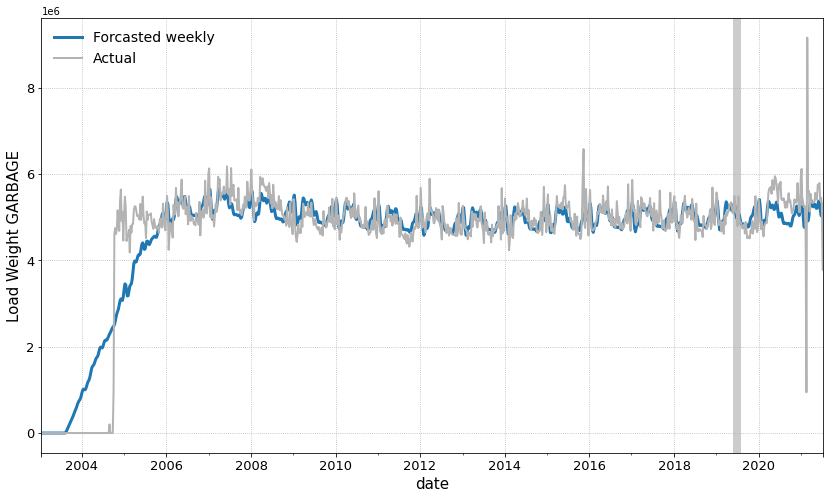

In [18]:
forecasted = forecast_week[["ds","yhat"]]
forecasted = forecasted.set_index('ds')

original = garbage_w.copy(deep=True)
original = original.set_index('ds')

f, ax = plt.subplots(figsize=(14,8))


forecasted.plot(ax=ax, ls='-', lw=3);
original.plot(ax=ax, ls='-', lw=2,color= '0.7');

ax.grid(ls=':')
ax.legend(['Forcasted weekly','Actual'], frameon=False, fontsize=14);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('Load Weight GARBAGE', fontsize=15);

ax.axvline('2019-06-30', color='0.8', lw=8, zorder=-1);

Forcatsed values are close to actual, this coinside with our intial analysis of having seasonality in Garbage collection.

#### 3.3 Cross-Validation and Evaluation of Model - GARBAGE COLLECTION Weekly

In [19]:
cv_garbage_w = cross_validation(model_garbage_w, initial='3840 days', period='180 days', horizon = '365 days')
performance_garbage_w = performance_metrics(cv_garbage_w)
performance_garbage_w.describe()

INFO:fbprophet:Making 10 forecasts with cutoffs between 2014-01-15 00:00:00 and 2018-06-23 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

horizon           mse           rmse            mae  \
count                         330  3.300000e+02     330.000000     330.000000   
mean            200 days 12:00:00  9.587059e+10  303178.293148  228864.137730   
std    95 days 09:46:06.770119357  3.983422e+10   62972.420033   40050.469087   
min              36 days 00:00:00  3.486931e+10  186733.258116  143030.193776   
25%             118 days 06:00:00  6.694360e+10  258734.471538  198557.198624   
50%             200 days 12:00:00  8.250691e+10  287240.158995  226372.938753   
75%             282 days 18:00:00  1.204780e+11  347099.412742  261432.719347   
max             365 days 00:00:00  2.026839e+11  450204.321508  309243.895061   

             mape       mdape    coverage  
count  330.000000  330.000000  330.000000  
mean     0.044853    0.035809    0.983013  
std      0.007044    0.007639    0.017349  
min      0.028662    0.021664    0.942308  
25%      0.039876    0.029718    0.980769  
50%      0.044230    0.034767    0.980769  
75%      0.050631    0.039582    1.000000  
max      0.059192    0.059271    1.000000

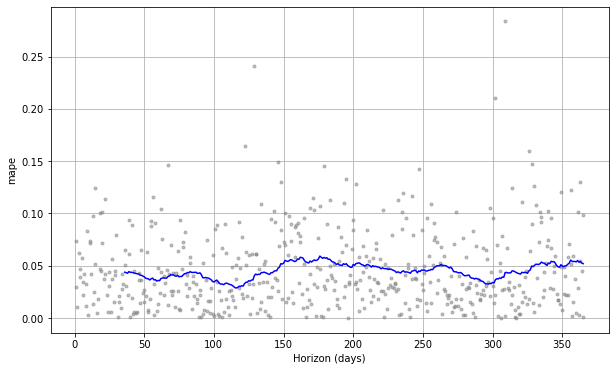

In [20]:
fig = plot_cross_validation_metric(cv_garbage_w, metric='mape')

Cross Validation shows the mean MAPE (Mean Absolute Percentage Error) to be 4.5 %, We get this socre on training set. Next we evaluate the model on test set.

In [21]:
# Calculating the MAPE ofthe model

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

pred = model_garbage_w.predict(pd.DataFrame(data_test["ds"]))
pred['yhat'] = pred['yhat'].clip(lower = 1)
mean_absolute_percentage_error(data_test['y'],pred['yhat'])

10.239318354903343

On the test set our model's MAPE score is 10.2% which is good indication that our forcasted model is performing well, next we will train out garbage collection model on whole dataset, this would be used to make future predictions.

In [22]:
model_garbage = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_garbage.fit(garbage_w)

#### 3.4 Forecasting and Future Trends - GARBAGE COLLECTION Weekly

In [23]:
garbage_data_25 = model_garbage.make_future_dataframe(periods=233, freq='1W')
garbage_future_data = garbage_data_25[garbage_data_25['ds']>'2021-07-09']
garbage_forcasted_25 = model_garbage.predict(garbage_future_data) 
plot_plotly(model_garbage,garbage_forcasted_25)

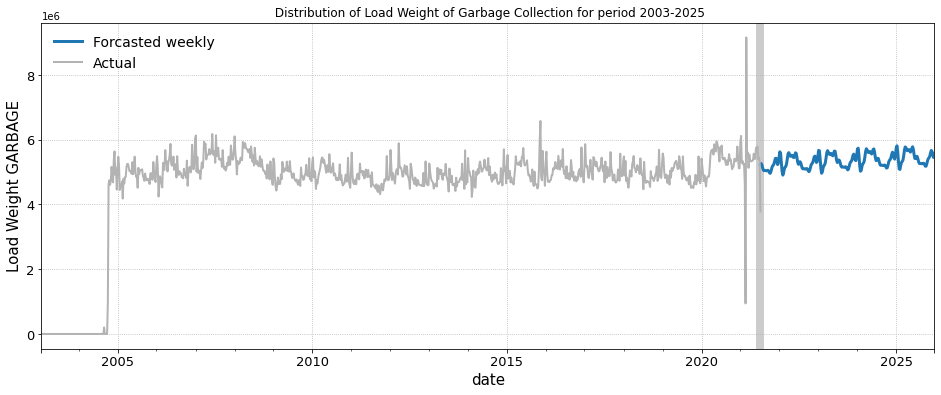

In [24]:
forecasted = garbage_forcasted_25[["ds","yhat"]]
forecasted = forecasted.set_index('ds')

original = garbage_w.copy(deep=True)
original = original.set_index('ds')

f, ax = plt.subplots(figsize=(16,6))

forecasted.plot(ax=ax, ls='-', lw=3);
original.plot(ax=ax, ls='-', lw=2,color= '0.7');

ax.grid(ls=':')
ax.legend(['Forcasted weekly','Actual'], frameon=False, fontsize=14);
ax.set_title(" Distribution of Load Weight of Garbage Collection for period 2003-2025")

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('Load Weight GARBAGE', fontsize=15);

ax.axvline('2021-07-09', color='0.8', lw=8, zorder=-1);

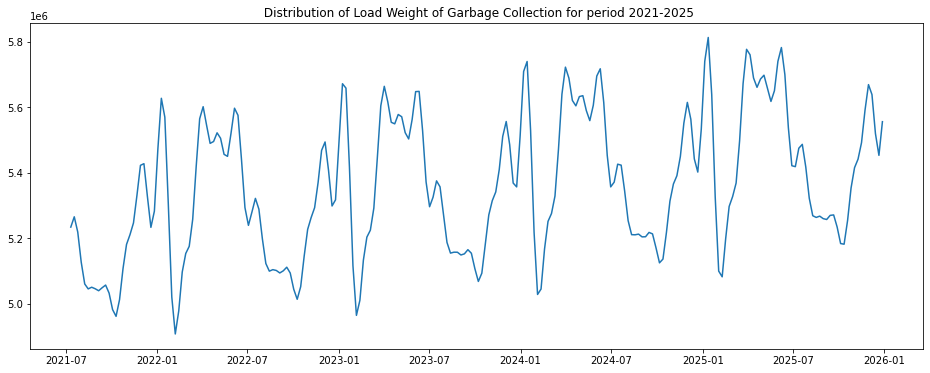

In [25]:
fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.plot(forecasted.index,forecasted['yhat'])
axes.set_title(" Distribution of Load Weight of Garbage Collection for period 2021-2025")
plt.show()

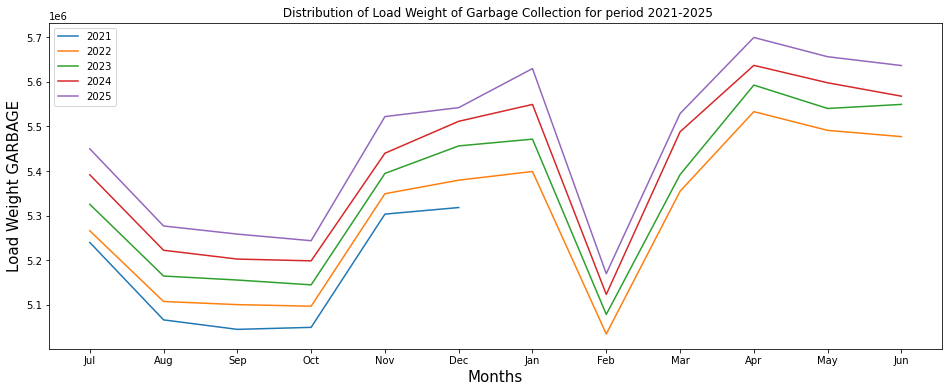

In [26]:
# Prepare data
df = garbage_forcasted_25.loc[:,['ds','yhat']]
df['year'] = [d.year for d in df['ds']]
df['month'] = [d.strftime('%b') for d in df['ds']]
years = df['year'].unique()

fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.set_xlabel('Months', fontsize=15)
plt.set_loglevel('WARNING')

axes.set_ylabel('Load Weight GARBAGE', fontsize=15);
axes.set_title(" Distribution of Load Weight of Garbage Collection for period 2021-2025")

        
for i,yr in enumerate(years):
    sns.lineplot(x=df.loc[df.year==yr, :]['month'],y=df.loc[df.year==yr, :]['yhat'],label=yr,ci=None);
    


Forcasted values of garbage collection shows the upward trend from the period 2021 to 2025. The trend of Garbage collection throughout the year is varying,
- October to January month shows the increase in Garbage Load Weight, this aline with Holiday periods, this might be an explaination why this trend happenindg.
- Lower point is from January to Febuary which is peak winter season in Austin Texas.(There might be some correlation of temperature and Load Weight)
- We see the upward trend again from Febuary and peak month is April.


### 4 Time Series Analysis and Model of SWEEPING Using Fbprophet 

#### 4.1 Analysis of SWEEPING

In [27]:
sweeping = waste[["Report Date","SWEEPING"]]
sweeping = sweeping.fillna(1)
sweeping = sweeping.rename(columns={'Report Date':'ds','SWEEPING':'y'})

sweeping_w = sweeping.groupby(pd.Grouper(key='ds', freq='1W')).sum()
sweeping_w.reset_index(inplace = True)

sweeping_2w = sweeping.groupby(pd.Grouper(key='ds', freq='2W')).sum()
sweeping_2w.reset_index(inplace = True)

sweeping_m = sweeping.groupby(pd.Grouper(key='ds', freq='1M')).sum()
sweeping_m.reset_index(inplace = True)

                        

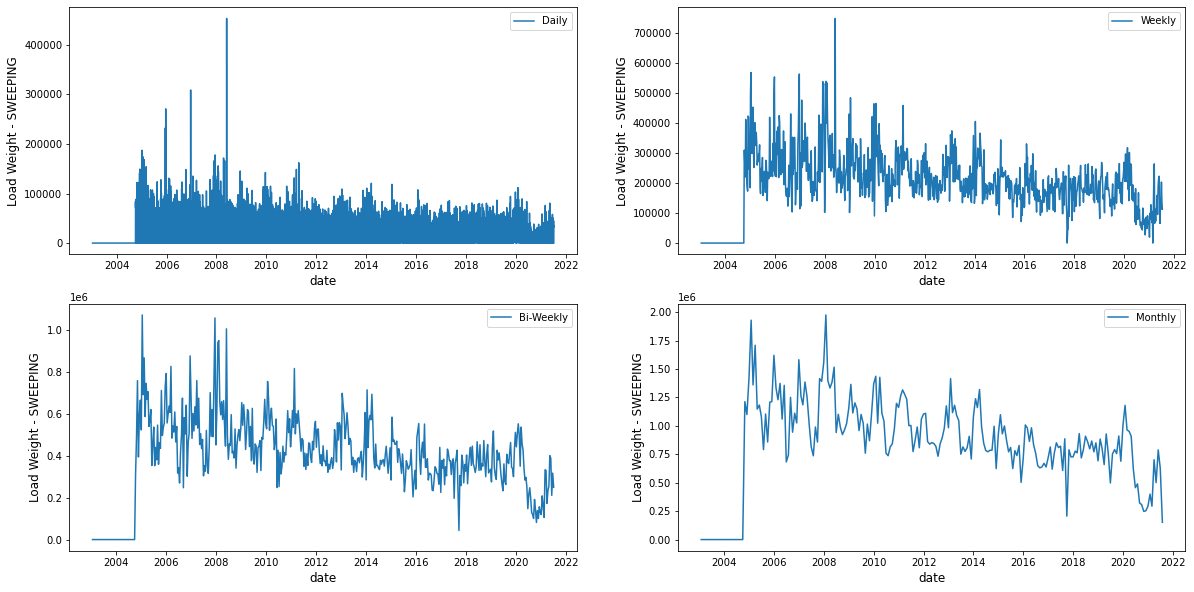

In [28]:
fig,axes = plt.subplots(2,2,figsize = (20,10))

legends = [['Daily','Weekly'],['Bi-Weekly','Monthly']]

axes[0,0].plot(sweeping['ds'],sweeping['y'])

axes[0,1].plot(sweeping_w['ds'],sweeping_w['y'])

axes[1,0].plot(sweeping_2w['ds'],sweeping_2w['y'])

axes[1,1].plot(sweeping_m['ds'],sweeping_m['y'])

for i in range(2):
    for j in range(2):
        axes[i,j].legend([legends[i][j]]);
        [l.set_fontsize(10) for l in axes[i,j].xaxis.get_ticklabels()]
        [l.set_fontsize(10) for l in axes[i,j].yaxis.get_ticklabels()]
        axes[i,j].set_xlabel('date', fontsize=12)
        axes[i,j].set_ylabel('Load Weight - SWEEPING', fontsize=12);


We did not find any seasonality in Daily, Weekly, Bi-Weekly and Monthly, we created different models for each periods and on the basis of MAPE score and SWEEPING schedule of Austin Texas selected Monthly model.

#### 4.2 Time Series Model of SWEEPING - MONTHLY

We are separating the time-series into a training set (the period 2003-01-13 to 2019-06-30 included) and a test set (the period ranging from the 2019-07-01 to the 2021-07-09). The model will be fitted on the training set, and evaluated on the test set (out of sample prediction), to ensure a fair evaluation of the performance of the model.

In [29]:
data_train = sweeping_m[sweeping_m['ds']<'2019-06-30']
data_test = sweeping_m[sweeping_m['ds']>='2019-06-30']

In [30]:
model_sweeping_m = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_sweeping_m.fit(data_train)
future_month = model_sweeping_m.make_future_dataframe(periods=27, freq='1M')

forecast_month = model_sweeping_m.predict(future_month)
forecast_month['yhat'] = forecast_month['yhat'].clip(lower=0)

plot_plotly(model_sweeping_m, forecast_month)


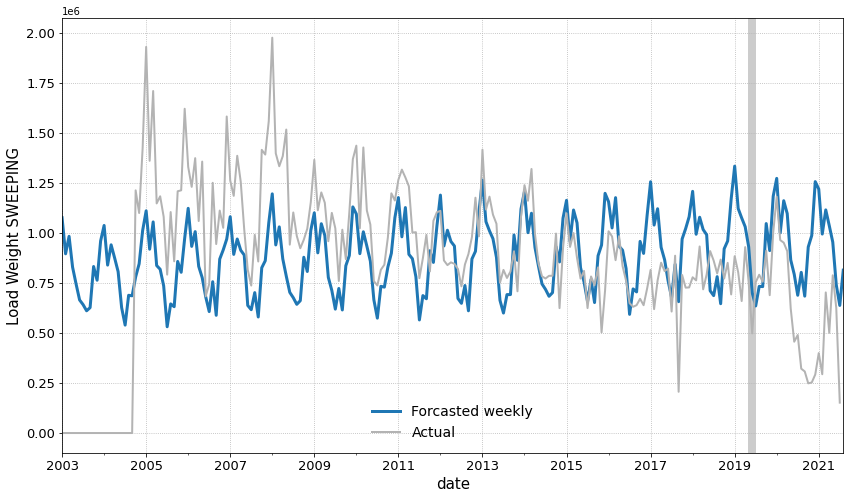

In [31]:
forecasted = forecast_month[["ds","yhat"]]
forecasted = forecasted.set_index('ds')

original = sweeping_m.copy(deep=True)
original = original.set_index('ds')

f, ax = plt.subplots(figsize=(14,8))


forecasted.plot(ax=ax, ls='-', lw=3);
original.plot(ax=ax, ls='-', lw=2,color= '0.7');

ax.grid(ls=':')
ax.legend(['Forcasted weekly','Actual'], frameon=False, fontsize=14);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('Load Weight SWEEPING', fontsize=15);

ax.axvline('2019-06-30', color='0.8', lw=8, zorder=-1);

Forcatsed values are not very similar to Actual, this could be because of ~81% missing values in SWEEPING Load Type. We implimented this model on monthly basis as its give lowest MAPE.

#### 4.3 Cross-Validation and Evaluation of Model - SWEEPING Weekly

In [32]:
cv_sweeping_m = cross_validation(model_sweeping_m, initial='3840 days', period='180 days', horizon = '365 days')
performance_sweeping_m = performance_metrics(cv_sweeping_m)
performance_sweeping_m.describe()

INFO:fbprophet:Making 10 forecasts with cutoffs between 2013-12-23 00:00:00 and 2018-05-31 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

horizon           mse           rmse  \
count                          109  1.090000e+02     109.000000   
mean   203 days 01:45:41.284403670  2.277816e+11  475659.549180   
std     96 days 02:06:09.099905143  3.687562e+10   39290.345073   
min               40 days 00:00:00  1.327662e+11  364370.939067   
25%              119 days 00:00:00  2.031306e+11  450700.113425   
50%              204 days 00:00:00  2.293758e+11  478931.917972   
75%              286 days 00:00:00  2.558131e+11  505779.718664   
max              365 days 00:00:00  3.025239e+11  550021.702327   

                 mae        mape       mdape    coverage  
count     109.000000  109.000000  109.000000  109.000000  
mean   433673.433879    0.601704    0.549518    0.681193  
std     38203.820041    0.097415    0.071400    0.082437  
min    317578.743403    0.400833    0.359127    0.500000  
25%    403721.086021    0.522034    0.501293    0.666667  
50%    437673.495320    0.579680    0.555732    0.666667  
75%    464397.198293    0.687992    0.611282    0.750000  
max    510856.650549    0.795475    0.684992    0.916667

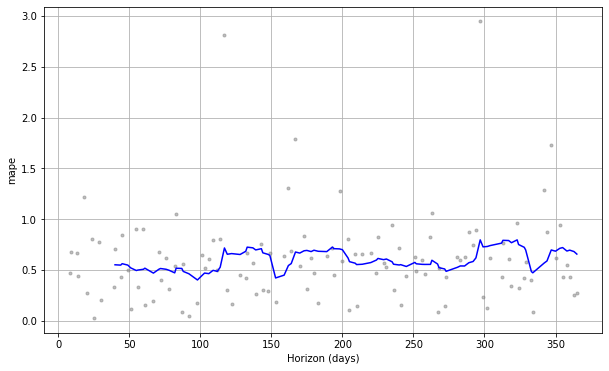

In [33]:
fig = plot_cross_validation_metric(cv_sweeping_m, metric='mape')

Cross Validation shows the mean MAPE (Mean Absolute Percentage Error) to be 60 %, We get this socre on training set. Next we evaluate the model on test set.

In [34]:
# Calculating the MAPE ofthe model

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

pred = model_sweeping_m.predict(pd.DataFrame(data_test["ds"]))
pred['yhat'] = pred['yhat'].clip(lower = 1)
mean_absolute_percentage_error(data_test['y'],pred['yhat'])

95.20127164141591

On the test set our model's MAPE score is 95.2% which is not good indication that our forcasted model is performing well, next we will train out sweeping model on whole dataset, this would be used to make future predictions.

In [35]:
model_sweeping = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_sweeping.fit(sweeping_m)

#### 4.4 Forecasting and Future Trends - SWEEPING Weekly

In [36]:
sweeping_data_25 = model_sweeping.make_future_dataframe(periods=232, freq='1W')
sweeping_future_data = sweeping_data_25[sweeping_data_25['ds']>'2021-07-09']
sweeping_forcasted_25 = model_sweeping.predict(sweeping_future_data) 
plot_plotly(model_sweeping,sweeping_forcasted_25)

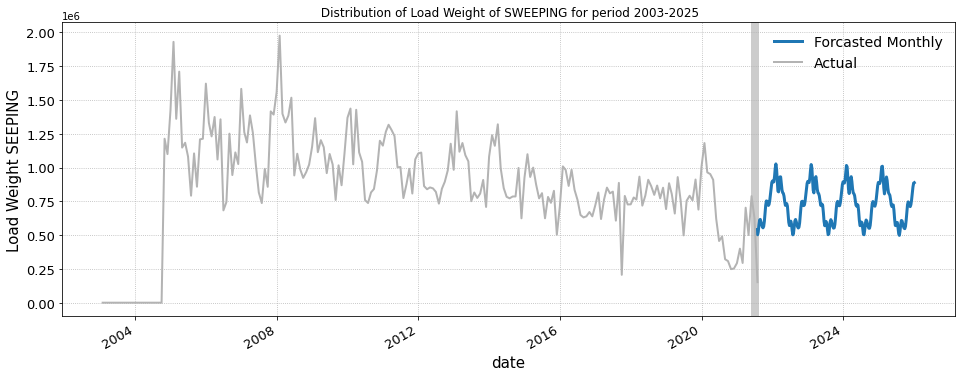

In [37]:
forecasted = sweeping_forcasted_25[["ds","yhat"]]
forecasted = forecasted.set_index('ds')

original = sweeping_m.copy(deep=True)
original = original.set_index('ds')

f, ax = plt.subplots(figsize=(16,6))

forecasted.plot(ax=ax, ls='-', lw=3);
original.plot(ax=ax, ls='-', lw=2,color= '0.7');

ax.grid(ls=':')
ax.legend(['Forcasted Monthly','Actual'], frameon=False, fontsize=14);
ax.set_title(" Distribution of Load Weight of SWEEPING for period 2003-2025")

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('Load Weight SEEPING', fontsize=15);

ax.axvline('2021-07-09', color='0.8', lw=8, zorder=-1);

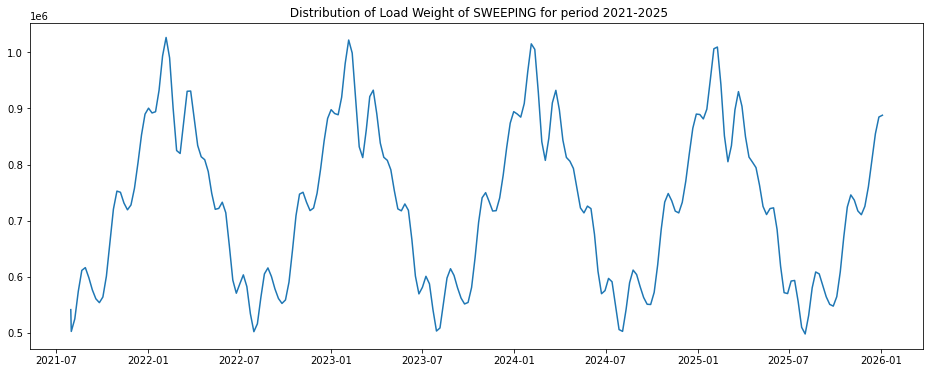

In [38]:
fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.plot(forecasted.index,forecasted['yhat'])
axes.set_title(" Distribution of Load Weight of SWEEPING for period 2021-2025")
plt.show()

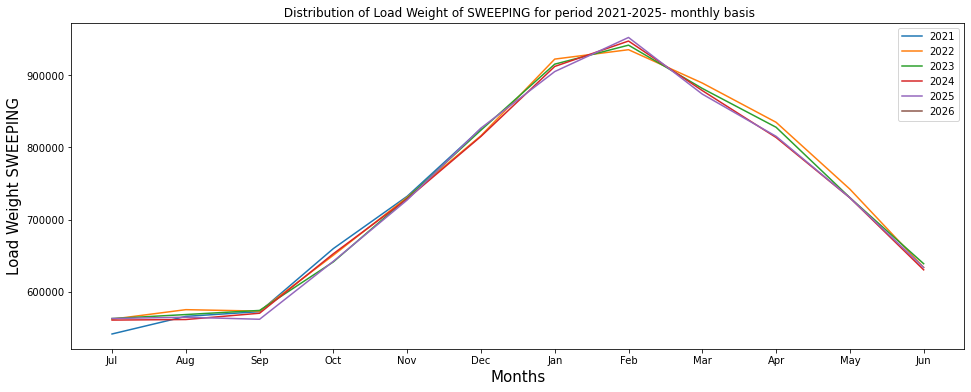

In [39]:
# Prepare data
df = sweeping_forcasted_25.loc[:,['ds','yhat']]
df['year'] = [d.year for d in df['ds']]
df['month'] = [d.strftime('%b') for d in df['ds']]
years = df['year'].unique()

fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.set_xlabel('Months', fontsize=15)
plt.set_loglevel('WARNING')

axes.set_ylabel('Load Weight SWEEPING', fontsize=15);
axes.set_title(" Distribution of Load Weight of SWEEPING for period 2021-2025- monthly basis")

        
for i,yr in enumerate(years):
    sns.lineplot(x=df.loc[df.year==yr, :]['month'],y=df.loc[df.year==yr, :]['yhat'],label=yr,ci=None);
    


Forcasted values of SWEEPING is saws same kind of trend for period 2021-2025,there is some trends on monthly basis
 - SWEEPING load is fairly constant for July to September
 - From September onwards we see the increase in Load Weight, and pick comes in Febuary. For peak winter season of Jan-Feb we are observing increase in Load weight.

### 5 Time Series Analysis and Model of RECYCLING Using Fbprophet 

#### 5.1 Analysis of RECYCLING Load Type

In [40]:
recycling = waste[["Report Date","RECYCLING"]]

recycling = recycling.rename(columns={'Report Date':'ds','RECYCLING':'y'})

recycling_w = recycling.groupby(pd.Grouper(key='ds', freq='1W')).sum()
recycling_w.reset_index(inplace = True)

recycling_2w = recycling.groupby(pd.Grouper(key='ds', freq='2W')).sum()
recycling_2w.reset_index(inplace = True)

recycling_m = recycling.groupby(pd.Grouper(key='ds', freq='1M')).sum()
recycling_m.reset_index(inplace = True)

                        

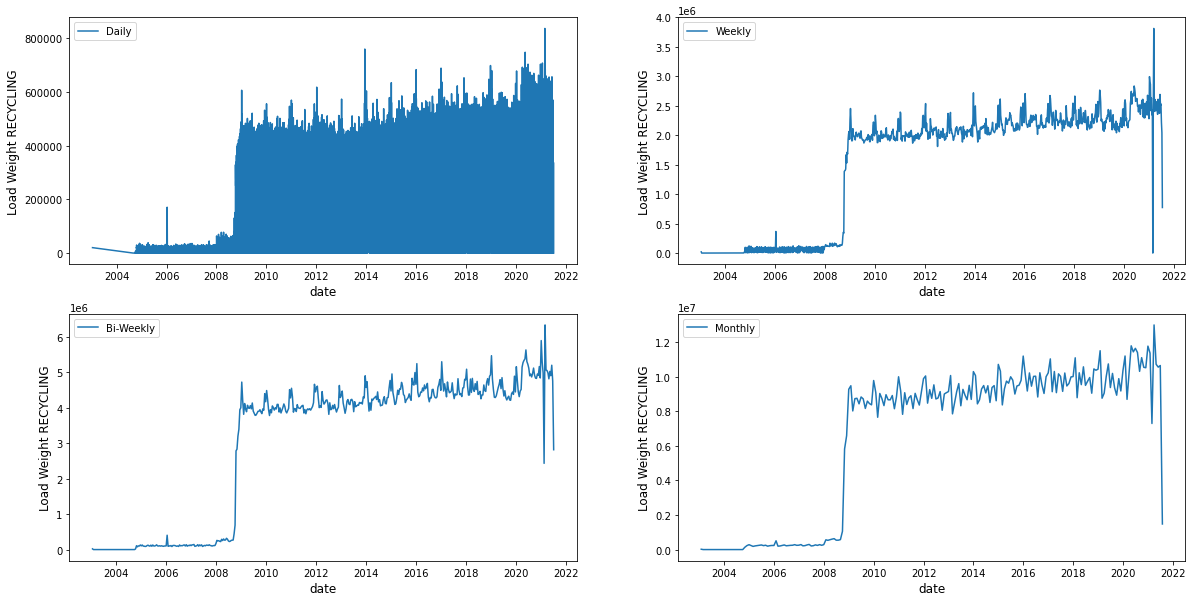

In [41]:
fig,axes = plt.subplots(2,2,figsize = (20,10))

legends = [['Daily','Weekly'],['Bi-Weekly','Monthly']]

axes[0,0].plot(recycling['ds'],recycling['y'])

axes[0,1].plot(recycling_w['ds'],recycling_w['y'])

axes[1,0].plot(recycling_2w['ds'],recycling_2w['y'])

axes[1,1].plot(recycling_m['ds'],recycling_m['y'])

for i in range(2):
    for j in range(2):
        axes[i,j].legend([legends[i][j]]);
        [l.set_fontsize(10) for l in axes[i,j].xaxis.get_ticklabels()]
        [l.set_fontsize(10) for l in axes[i,j].yaxis.get_ticklabels()]
        axes[i,j].set_xlabel('date', fontsize=12)
        axes[i,j].set_ylabel('Load Weight RECYCLING', fontsize=12);


We do some seasonality in Weekly, Bi-Weekly and Monthly, we created different models for each periods and on the basis of MAPE score and RECYCLING schedule of Austin Texas selected Bi-Weekly model.

#### 5.2 Time Series Model of RECYCLING - BI-WEEKLY

We are separating the time-series into a training set (the period 2009-01-13 to 2019-06-30 included) and a test set (the period ranging from the 2019-07-01 to the 2021-07-09). The model will be fitted on the training set, and evaluated on the test set (out of sample prediction), to ensure a fair evaluation of the performance of the model.

In [42]:
data_train = recycling_2w[(recycling_2w['ds']<'2019-06-30') & (recycling_2w['ds']>'2009-01-01')]
data_test = recycling_2w[recycling_2w['ds']>='2019-06-30']

In [43]:
model_recycling_2w = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_recycling_2w.fit(data_train)
future_2week = model_recycling_2w.make_future_dataframe(periods=53, freq='2W')

forecast_2week = model_recycling_2w.predict(future_2week)
forecast_2week['yhat'] = forecast_2week['yhat'].clip(lower=0)

plot_plotly(model_recycling_2w, forecast_2week)


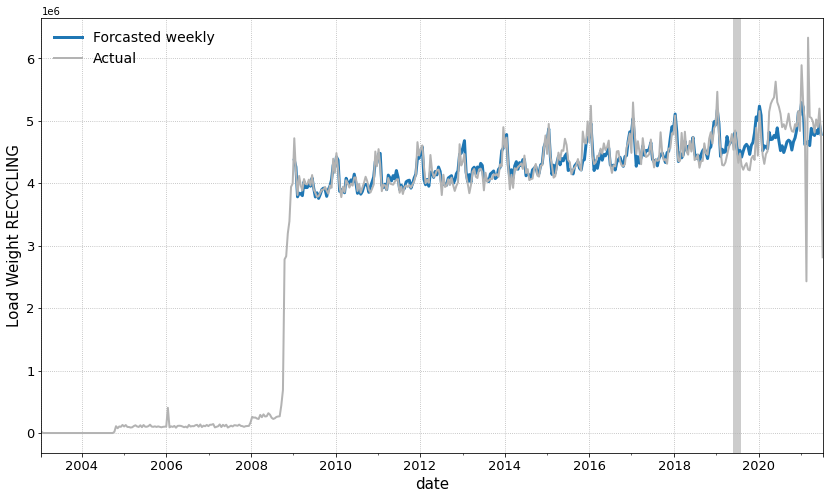

In [44]:
forecasted = forecast_2week[["ds","yhat"]]
forecasted = forecasted.set_index('ds')

original = recycling_2w.copy(deep=True)
original = original.set_index('ds')

f, ax = plt.subplots(figsize=(14,8))


forecasted.plot(ax=ax, ls='-', lw=3);
original.plot(ax=ax, ls='-', lw=2,color= '0.7');

ax.grid(ls=':')
ax.legend(['Forcasted weekly','Actual'], frameon=False, fontsize=14);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('Load Weight RECYCLING', fontsize=15);

ax.axvline('2019-06-30', color='0.8', lw=8, zorder=-1);

Our Forcatsed values are close to actual, this coinside with our intial analysis of having seasonality in recycling.

#### 5.3 Cross-Validation and Evaluation of Model - RECYCLING Bi-WEEKLY

In [45]:
cv_recycling_2w = cross_validation(model_recycling_2w, initial='2840 days', period='180 days', horizon = '365 days')
performance_recycling_2w = performance_metrics(cv_recycling_2w)
performance_recycling_2w.describe()

INFO:fbprophet:Making 4 forecasts with cutoffs between 2016-12-23 00:00:00 and 2018-06-16 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

horizon           mse           rmse            mae  \
count                          96  9.600000e+01      96.000000      96.000000   
mean            201 days 00:00:00  2.686227e+10  160157.550561  132936.132386   
std    97 days 10:41:10.575230811  1.128355e+10   34994.078585   35004.556181   
min              37 days 00:00:00  3.965986e+09   62976.072237   54047.145290   
25%             119 days 00:00:00  1.896568e+10  137715.918806  111348.392731   
50%             201 days 00:00:00  2.564920e+10  160153.658164  128793.245813   
75%             283 days 00:00:00  3.113495e+10  176443.830519  151871.605786   
max             365 days 00:00:00  5.436071e+10  233153.825183  215066.308661   

            mape      mdape   coverage  
count  96.000000  96.000000  96.000000  
mean    0.029187   0.027660   0.518750  
std     0.007800   0.010712   0.193207  
min     0.011914   0.011265   0.100000  
25%     0.024155   0.018060   0.400000  
50%     0.028314   0.026464   0.500000  
75%     0.033419   0.035507   0.600000  
max     0.048186   0.050497   1.000000

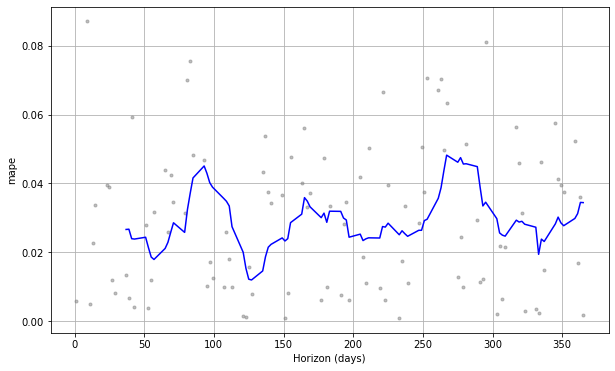

In [46]:
fig = plot_cross_validation_metric(cv_recycling_2w, metric='mape')

Cross Validation shows the mean MAPE (Mean Absolute Percentage Error) to be 2.9 %, We get this socre on training set. Next we evaluate the model on test set.

In [47]:
# Calculating the MAPE ofthe model

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

pred = model_recycling_2w.predict(pd.DataFrame(data_test["ds"]))
pred['yhat'] = pred['yhat'].clip(lower = 1)
mean_absolute_percentage_error(data_test['y'],pred['yhat'])

8.805154092343523

On the test set our model's MAPE score is 8.8% which is good indication that our forcasted model is performing well, next we will train out RECYCLING model on whole dataset, this would be used to make future predictions.

In [48]:
model_recycling = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_recycling.fit(recycling_2w)

#### 5.4 Forecasting and Future Trends - RECYCLING Bi-Weekly

In [49]:
recycling_data_25 = model_recycling.make_future_dataframe(periods=233, freq='1W')
recycling_future_data = recycling_data_25[recycling_data_25['ds']>'2021-07-09']
recycling_forcasted_25 = model_recycling.predict(recycling_future_data) 
plot_plotly(model_recycling,recycling_forcasted_25)

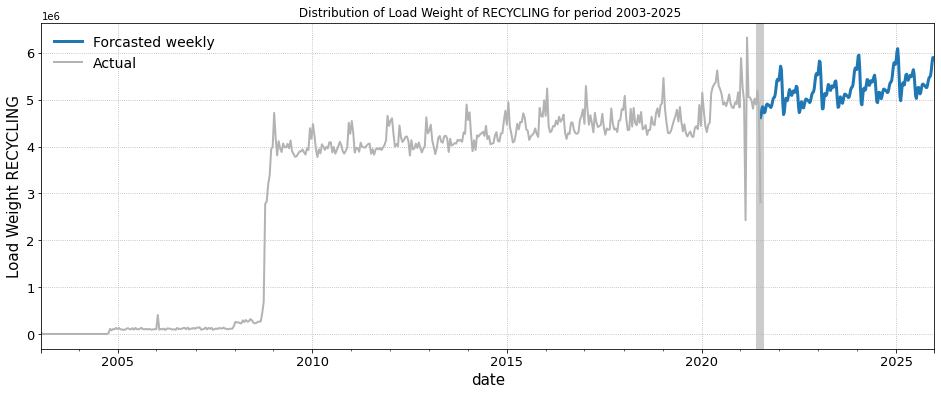

In [50]:
forecasted = recycling_forcasted_25[["ds","yhat"]]
forecasted = forecasted.set_index('ds')

original = recycling_2w.copy(deep=True)
original = original.set_index('ds')

f, ax = plt.subplots(figsize=(16,6))

forecasted.plot(ax=ax, ls='-', lw=3);
original.plot(ax=ax, ls='-', lw=2,color= '0.7');

ax.grid(ls=':')
ax.legend(['Forcasted weekly','Actual'], frameon=False, fontsize=14);
ax.set_title(" Distribution of Load Weight of RECYCLING for period 2003-2025")

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('Load Weight RECYCLING', fontsize=15);

ax.axvline('2021-07-09', color='0.8', lw=8, zorder=-1);

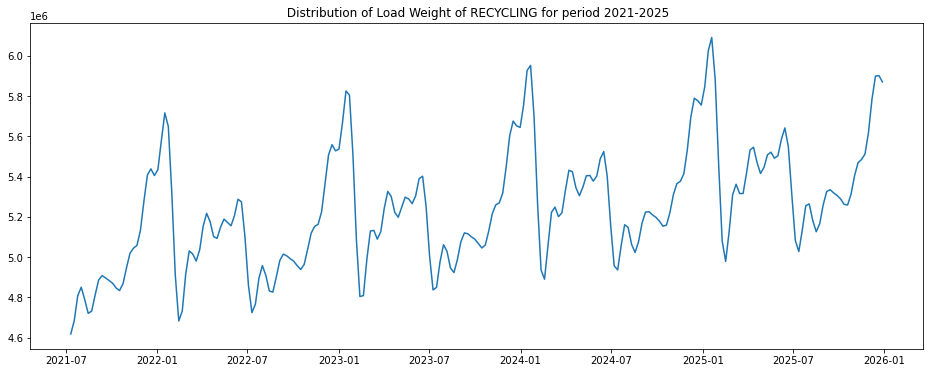

In [51]:
fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.plot(forecasted.index,forecasted['yhat'])
axes.set_title(" Distribution of Load Weight of RECYCLING for period 2021-2025")
plt.show()

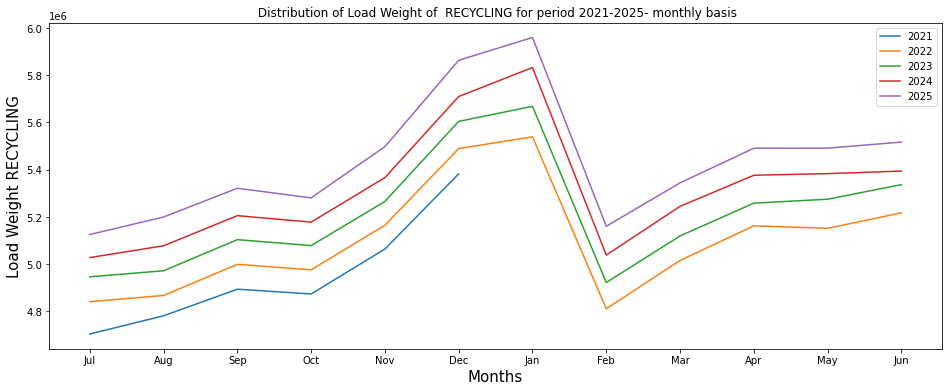

In [111]:
# Prepare data
df = recycling_forcasted_25.loc[:,['ds','yhat']]
df['year'] = [d.year for d in df['ds']]
df['month'] = [d.strftime('%b') for d in df['ds']]
years = df['year'].unique()

fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.set_xlabel('Months', fontsize=15)
plt.set_loglevel('WARNING')

axes.set_ylabel('Load Weight RECYCLING', fontsize=15);
axes.set_title(" Distribution of Load Weight of  RECYCLING for period 2021-2025- monthly basis")

        
for i,yr in enumerate(years):
    sns.lineplot(x=df.loc[df.year==yr, :]['month'],y=df.loc[df.year==yr, :]['yhat'],label=yr,ci=None);
    


Forcasted values of RECYCLING shows the upward trend from the period 2021 to 2025. The trend of RECYCLING throughout the year is varying,
- October to January month shows the increase in recycling Load Weight, this aline with Holiday periods, this might be an explaination why this trend happenindg.
- Lower point is from January to Febuary which is peak winter season in Austin Texas.(There might be some correlation of temperature and Load Weight)
- We see the upward trend again from Febuary.


### 6 Time Series Analysis and Model of COMPOSTABLE Using Fbprophet 

#### 6.1 Analysis of COMPOSTABLE Load Type

In [53]:
compostable = waste[["Report Date","COMPOSTABLE"]]
#compostable.fillna(0,inplace=True)
compostable = compostable.rename(columns={'Report Date':'ds','COMPOSTABLE':'y'})

compostable_w = compostable.groupby(pd.Grouper(key='ds', freq='1W')).sum()
compostable_w.reset_index(inplace = True)

compostable_2w = compostable.groupby(pd.Grouper(key='ds', freq='2W')).sum()
compostable_2w.reset_index(inplace = True)

compostable_m = compostable.groupby(pd.Grouper(key='ds', freq='1M')).sum()
compostable_m.reset_index(inplace = True)

                        

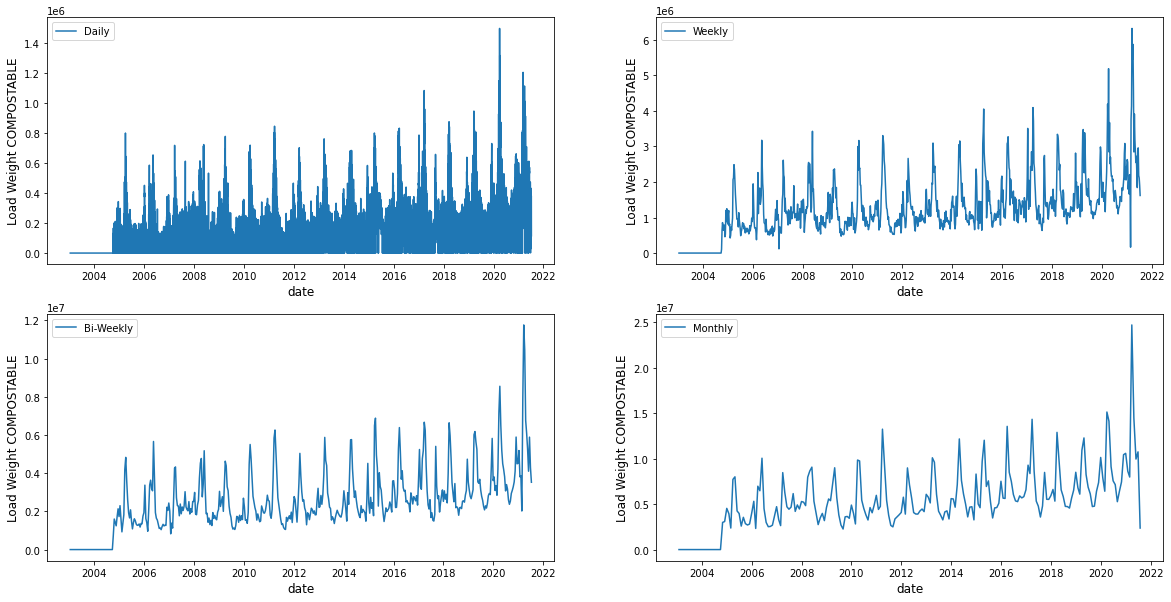

In [54]:
fig,axes = plt.subplots(2,2,figsize = (20,10))

legends = [['Daily','Weekly'],['Bi-Weekly','Monthly']]

axes[0,0].plot(compostable['ds'],compostable['y'])

axes[0,1].plot(compostable_w['ds'],compostable_w['y'])

axes[1,0].plot(compostable_2w['ds'],compostable_2w['y'])

axes[1,1].plot(compostable_m['ds'],compostable_m['y'])

for i in range(2):
    for j in range(2):
        axes[i,j].legend([legends[i][j]]);
        [l.set_fontsize(10) for l in axes[i,j].xaxis.get_ticklabels()]
        [l.set_fontsize(10) for l in axes[i,j].yaxis.get_ticklabels()]
        axes[i,j].set_xlabel('date', fontsize=12)
        axes[i,j].set_ylabel('Load Weight COMPOSTABLE', fontsize=12);


We do some seasonality in Daily, Weekly, Bi-Weekly and Monthly, we created different models for each periods and on the basis of MAPE score and COMPOSTABLE schedule of Austin Texas selected Bi-weekly model.

#### 6.2 Time Series Model of COMPOSTABLE - Bi-WEEKLY

We are separating the time-series into a training set (the period 2003-01-13 to 2019-06-30 included) and a test set (the period ranging from the 2019-07-01 to the 2021-07-09). The model will be fitted on the training set, and evaluated on the test set (out of sample prediction), to ensure a fair evaluation of the performance of the model.

In [55]:
data_train = compostable_2w[compostable_2w['ds']<'2019-06-30']
data_test = compostable_2w[compostable_2w['ds']>='2019-06-30']

In [56]:
model_compostable_2w = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_compostable_2w.fit(data_train)
future_2week = model_compostable_2w.make_future_dataframe(periods=54, freq='2W')

forecast_2week = model_compostable_2w.predict(future_2week)
forecast_2week['yhat'] = forecast_2week['yhat'].clip(lower=0)

plot_plotly(model_compostable_2w, forecast_2week)


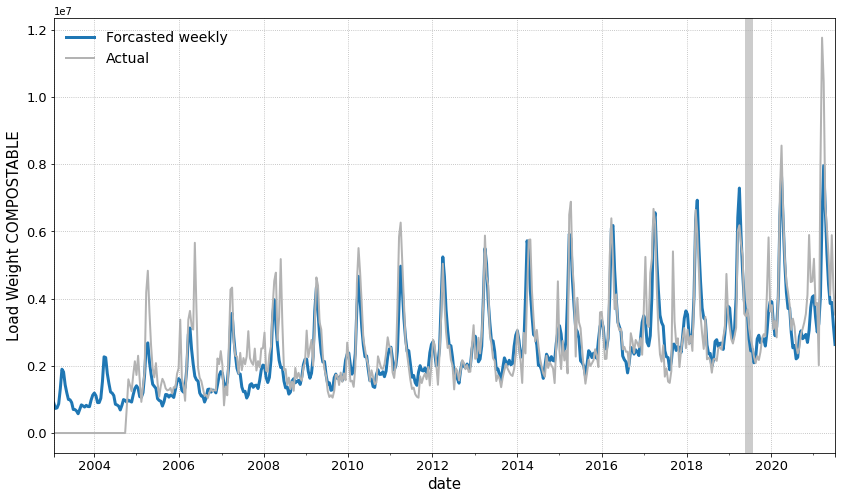

In [57]:
forecasted = forecast_2week[["ds","yhat"]]
forecasted = forecasted.set_index('ds')

original = compostable_2w.copy(deep=True)
original = original.set_index('ds')

f, ax = plt.subplots(figsize=(14,8))


forecasted.plot(ax=ax, ls='-', lw=3);
original.plot(ax=ax, ls='-', lw=2,color= '0.7');

ax.grid(ls=':')
ax.legend(['Forcasted weekly','Actual'], frameon=False, fontsize=14);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('Load Weight COMPOSTABLE', fontsize=15);

ax.axvline('2019-06-30', color='0.8', lw=8, zorder=-1);

Our Forcatsed values are close to actual, this coinside with our intial analysis of having seasonality in COMPOSTABLE

#### 6.3 Cross-Validation and Evaluation of Model - COMPOSTABLE Bi-Weekly

In [58]:
cv_compostable_2w = cross_validation(model_compostable_2w, initial='3840 days', period='180 days', horizon = '365 days')
performance_compostable_2w = performance_metrics(cv_compostable_2w)
performance_compostable_2w.describe()

INFO:fbprophet:Making 10 forecasts with cutoffs between 2014-01-08 00:00:00 and 2018-06-16 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

horizon           mse          rmse            mae  \
count                         165  1.650000e+02  1.650000e+02     165.000000   
mean            201 days 00:00:00  6.923327e+11  8.172723e+05  597711.750784   
std    95 days 13:13:29.293080675  2.601078e+11  1.566764e+05   90423.794045   
min              37 days 00:00:00  1.756609e+11  4.191192e+05  369569.207932   
25%             119 days 00:00:00  5.540447e+11  7.443418e+05  547917.616689   
50%             201 days 00:00:00  6.642205e+11  8.149972e+05  600221.263213   
75%             283 days 00:00:00  7.899108e+11  8.887692e+05  646969.296289   
max             365 days 00:00:00  1.360545e+12  1.166424e+06  801928.790030   

             mape       mdape    coverage  
count  165.000000  165.000000  165.000000  
mean     0.214405    0.148390    0.785781  
std      0.032824    0.025435    0.082329  
min      0.148421    0.092514    0.653846  
25%      0.195788    0.130292    0.730769  
50%      0.217476    0.153967    0.769231  
75%      0.233522    0.162342    0.807692  
max      0.288245    0.205789    1.000000

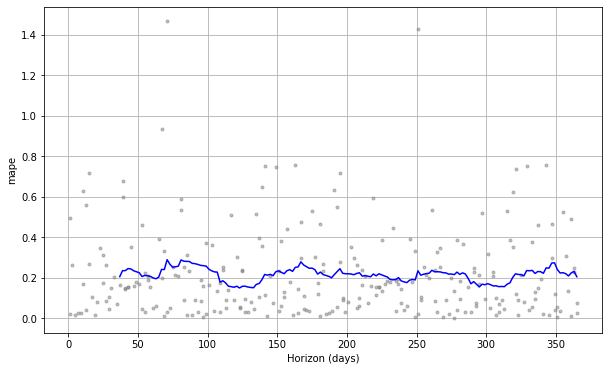

In [59]:
fig = plot_cross_validation_metric(cv_compostable_2w, metric='mape')

Cross Validation shows the mean MAPE (Mean Absolute Percentage Error) to be 21 %, We get this socre on training set. Next we evaluate the model on test set.

In [60]:
# Calculating the MAPE ofthe model

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

pred = model_compostable_2w.predict(pd.DataFrame(data_test["ds"]))
pred['yhat'] = pred['yhat'].clip(lower = 1)
mean_absolute_percentage_error(data_test['y'],pred['yhat'])

16.056351696717787

On the test set our model's MAPE score is 16 % which is very good indication that our forcasted model is performing well, next we will train out compostable model on whole dataset, this would be used to make future predictions.

In [61]:
model_compostable = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_compostable.fit(compostable_2w)

#### 6.4 Forecasting and Future Trends - COMPOSTABLE Bi-Weekly

In [62]:
compostable_data_25 = model_compostable.make_future_dataframe(periods=116, freq='2W')
compostable_future_data = compostable_data_25[compostable_data_25['ds']>'2021-07-09']
compostable_forcasted_25 = model_compostable.predict(compostable_future_data) 
plot_plotly(model_compostable,compostable_forcasted_25)

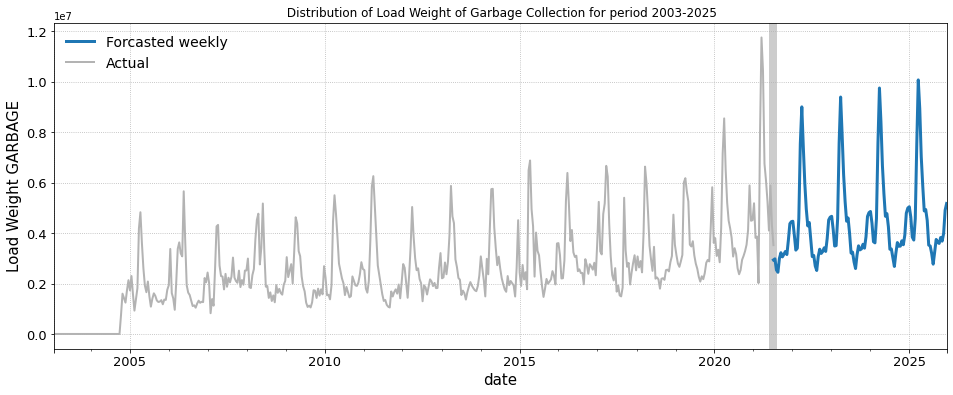

In [63]:
forecasted = compostable_forcasted_25[["ds","yhat"]]
forecasted = forecasted.set_index('ds')

original = compostable_2w.copy(deep=True)
original = original.set_index('ds')

f, ax = plt.subplots(figsize=(16,6))

forecasted.plot(ax=ax, ls='-', lw=3);
original.plot(ax=ax, ls='-', lw=2,color= '0.7');

ax.grid(ls=':')
ax.legend(['Forcasted weekly','Actual'], frameon=False, fontsize=14);
ax.set_title(" Distribution of Load Weight of Garbage Collection for period 2003-2025")

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('Load Weight GARBAGE', fontsize=15);

ax.axvline('2021-07-09', color='0.8', lw=8, zorder=-1);

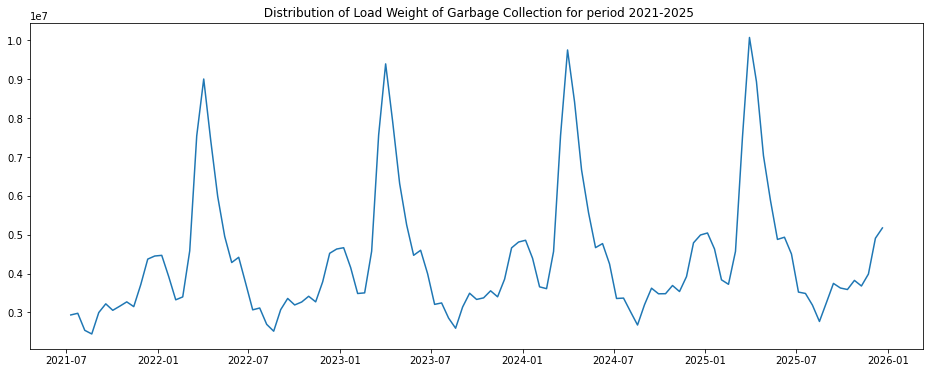

In [64]:
fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.plot(forecasted.index,forecasted['yhat'])
axes.set_title(" Distribution of Load Weight of Garbage Collection for period 2021-2025")
plt.show()

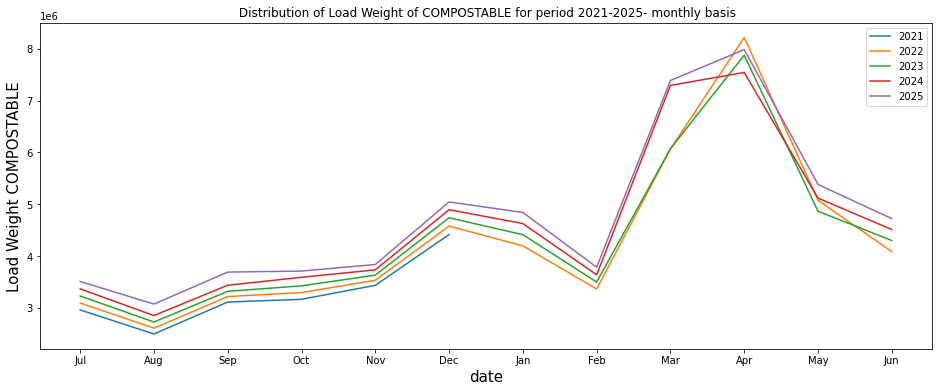

In [112]:
# Prepare data
df = compostable_forcasted_25.loc[:,['ds','yhat']]
df['year'] = [d.year for d in df['ds']]
df['month'] = [d.strftime('%b') for d in df['ds']]
years = df['year'].unique()

fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.set_xlabel('date', fontsize=15)
plt.set_loglevel('WARNING')

axes.set_ylabel('Load Weight COMPOSTABLE', fontsize=15);
axes.set_title(" Distribution of Load Weight of COMPOSTABLE for period 2021-2025- monthly basis")

        
for i,yr in enumerate(years):
    sns.lineplot(x=df.loc[df.year==yr, :]['month'],y=df.loc[df.year==yr, :]['yhat'],label=yr,ci=None);
    


Forcasted values of COMPOSTABLE shows in general upward trend from the period 2021 to 2025. The trend of COMPOSTABLE throughout the year is varying,
- Febuary to April have max peak, this period aline with spring seasons, main contribution in compostable is from Yard Trimming and Brush. After winter this trends justify the Load Weight.
- Lower point is in August.


### 7 Time Series Analysis and Model of REUSABLE (BULK+TIRES) Using Fbprophet 

#### 7.1 Analysis of REUSABLE

In [66]:
reusable = waste[["Report Date","REUSABLE"]]
#reusable.fillna(0,inplace=True)
reusable = reusable.rename(columns={'Report Date':'ds','REUSABLE':'y'})

reusable_w = reusable.groupby(pd.Grouper(key='ds', freq='1W')).sum()
reusable_w.reset_index(inplace = True)

reusable_2w = reusable.groupby(pd.Grouper(key='ds', freq='2W')).sum()
reusable_2w.reset_index(inplace = True)

reusable_m = reusable.groupby(pd.Grouper(key='ds', freq='1M')).sum()
reusable_m.reset_index(inplace = True)

                        

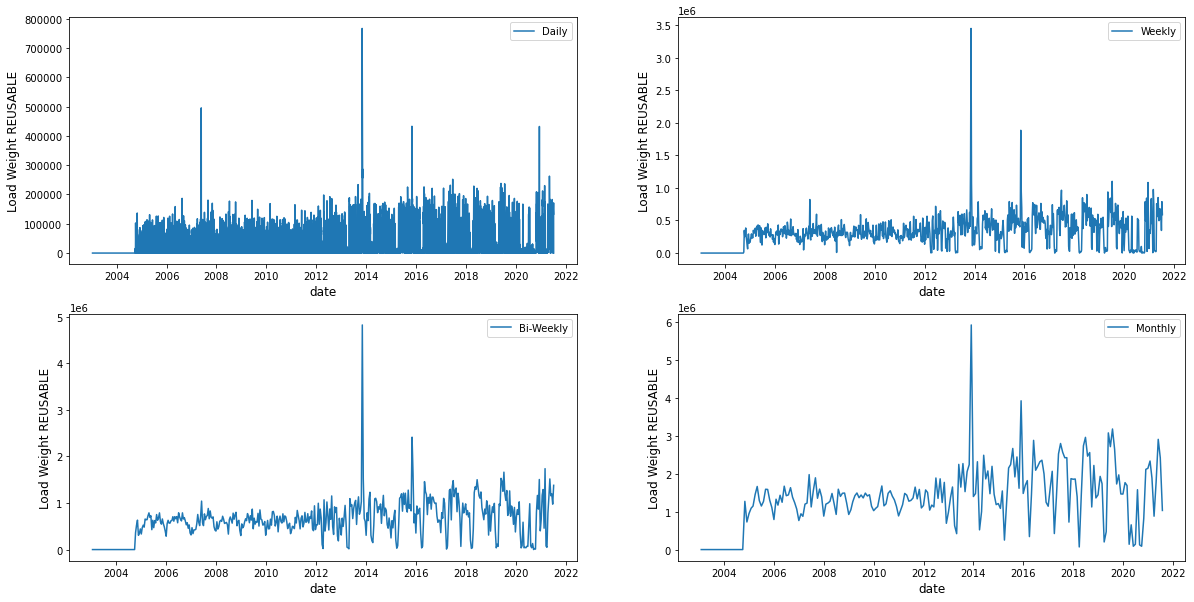

In [67]:
fig,axes = plt.subplots(2,2,figsize = (20,10))

legends = [['Daily','Weekly'],['Bi-Weekly','Monthly']]

axes[0,0].plot(reusable['ds'],reusable['y'])

axes[0,1].plot(reusable_w['ds'],reusable_w['y'])

axes[1,0].plot(reusable_2w['ds'],reusable_2w['y'])

axes[1,1].plot(reusable_m['ds'],reusable_m['y'])

for i in range(2):
    for j in range(2):
        axes[i,j].legend([legends[i][j]]);
        [l.set_fontsize(10) for l in axes[i,j].xaxis.get_ticklabels()]
        [l.set_fontsize(10) for l in axes[i,j].yaxis.get_ticklabels()]
        axes[i,j].set_xlabel('date', fontsize=12)
        axes[i,j].set_ylabel('Load Weight REUSABLE', fontsize=12);


We do some seasonality in Weekly, Bi-Weekly and Monthly, we created different models for each periods and on the basis of MAPE score and REUSABLE schedule of Austin Texas selected monthly model.

#### 7.2 Time Series Model of REUSABLE - Monthly

We are separating the time-series into a training set (the period 2003-01-13 to 2019-06-30 included) and a test set (the period ranging from the 2019-07-01 to the 2021-07-09). The model will be fitted on the training set, and evaluated on the test set (out of sample prediction), to ensure a fair evaluation of the performance of the model.

In [68]:
data_train = reusable_m[reusable_m['ds']<'2019-06-30']
data_test = reusable_m[reusable_m['ds']>='2019-06-30']

In [70]:
model_reusable_m = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_reusable_m.fit(data_train)
future_month = model_reusable_m.make_future_dataframe(periods=27, freq='1M')

forecast_month = model_reusable_m.predict(future_month)
forecast_month['yhat'] = forecast_month['yhat'].clip(lower=0)

plot_plotly(model_reusable_m, forecast_month)


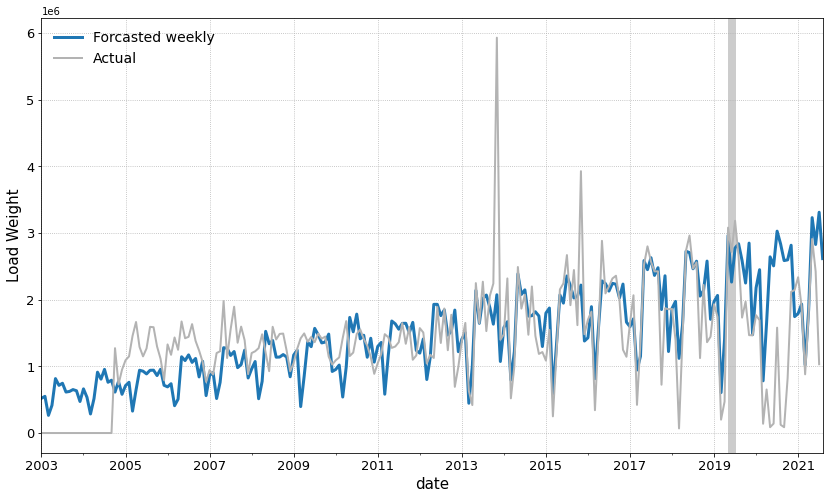

In [72]:
forecasted = forecast_month[["ds","yhat"]]
forecasted = forecasted.set_index('ds')

original = reusable_m.copy(deep=True)
original = original.set_index('ds')

f, ax = plt.subplots(figsize=(14,8))


forecasted.plot(ax=ax, ls='-', lw=3);
original.plot(ax=ax, ls='-', lw=2,color= '0.7');

ax.grid(ls=':')
ax.legend(['Forcasted weekly','Actual'], frameon=False, fontsize=14);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('Load Weight', fontsize=15);

ax.axvline('2019-06-30', color='0.8', lw=8, zorder=-1);

Our Forcatsed values are somewhat coincide with actuals but for unseen period after 2019-06 its performance is not good.This maybe an indication that reusable waste dont have any trends and seasonality.

#### 7.3 Cross-Validation and Evaluation of Model - REUSABLE Monthly

In [73]:
cv_reusable_m = cross_validation(model_reusable_m, initial='3840 days', period='180 days', horizon = '365 days')
performance_reusable_m = performance_metrics(cv_reusable_m)
performance_reusable_m.describe()

INFO:fbprophet:Making 10 forecasts with cutoffs between 2013-12-23 00:00:00 and 2018-05-31 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

horizon           mse           rmse  \
count                          109  1.090000e+02     109.000000   
mean   203 days 01:45:41.284403670  4.806901e+11  661251.124966   
std     96 days 02:06:09.099905143  2.771128e+11  209378.319113   
min               40 days 00:00:00  1.048546e+11  323812.545683   
25%              119 days 00:00:00  2.020611e+11  449512.038331   
50%              204 days 00:00:00  4.433596e+11  665852.538190   
75%              286 days 00:00:00  7.191960e+11  848054.232990   
max              365 days 00:00:00  9.692716e+11  984515.945026   

                 mae        mape       mdape    coverage  
count     109.000000  109.000000  109.000000  109.000000  
mean   516317.183593    0.888714    0.270462    0.720948  
std    185866.046266    0.939716    0.210965    0.161723  
min    189429.635086    0.114940    0.025743    0.416667  
25%    342243.487464    0.213225    0.139468    0.583333  
50%    516151.490421    0.457977    0.179362    0.750000  
75%    688881.888865    1.036670    0.401152    0.916667  
max    797152.919080    2.939996    0.870665    1.000000

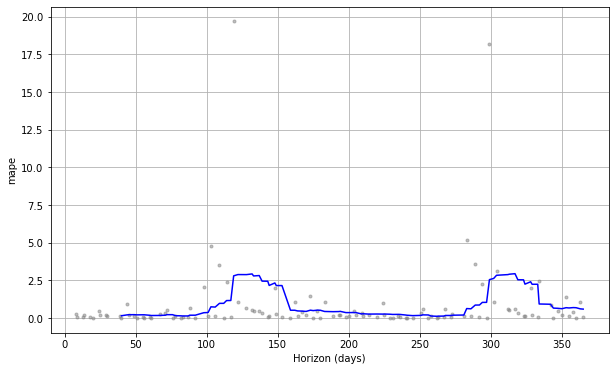

In [74]:
fig = plot_cross_validation_metric(cv_reusable_m, metric='mape')

Cross Validation shows the mean MAPE (Mean Absolute Percentage Error) to be 88 %, We get this socre on training set. Next we evaluate the model on test set.

In [75]:
# Calculating the MAPE ofthe model

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

pred = model_reusable_m.predict(pd.DataFrame(data_test["ds"]))
pred['yhat'] = pred['yhat'].clip(lower = 1)
mean_absolute_percentage_error(data_test['y'],pred['yhat'])

429.6848452317695

On the test set our model's MAPE score is 429 % which is indication that this load type perfornace is not adequate, next we will train out REUSABLE model on whole dataset, this would be used to make future predictions.

In [76]:
model_reusable = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_reusable.fit(reusable_m)

#### 7.4 Forecasting and Future Trends - REUSABLE Monthly

In [77]:
reusable_data_25 = model_reusable.make_future_dataframe(periods=233, freq='1W')
reusable_future_data = reusable_data_25[reusable_data_25['ds']>'2021-07-09']
reusable_forcasted_25 = model_reusable.predict(reusable_future_data) 
plot_plotly(model_reusable,reusable_forcasted_25)

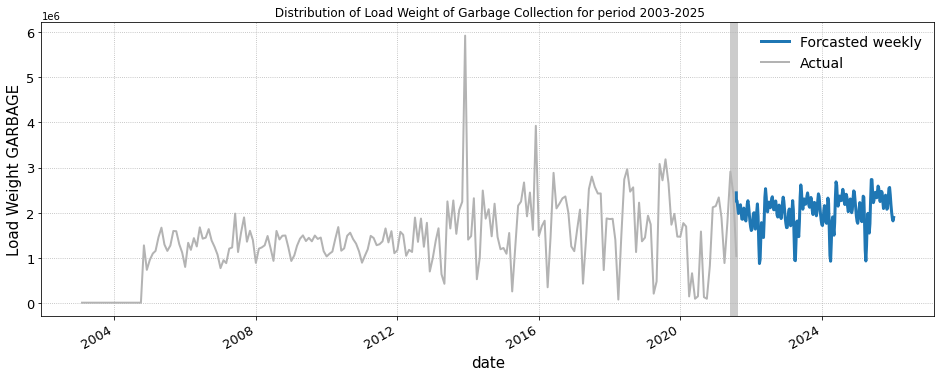

In [78]:
forecasted = reusable_forcasted_25[["ds","yhat"]]
forecasted = forecasted.set_index('ds')

original = reusable_m.copy(deep=True)
original = original.set_index('ds')

f, ax = plt.subplots(figsize=(16,6))

forecasted.plot(ax=ax, ls='-', lw=3);
original.plot(ax=ax, ls='-', lw=2,color= '0.7');

ax.grid(ls=':')
ax.legend(['Forcasted weekly','Actual'], frameon=False, fontsize=14);
ax.set_title(" Distribution of Load Weight of Garbage Collection for period 2003-2025")

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('Load Weight GARBAGE', fontsize=15);

ax.axvline('2021-07-09', color='0.8', lw=8, zorder=-1);

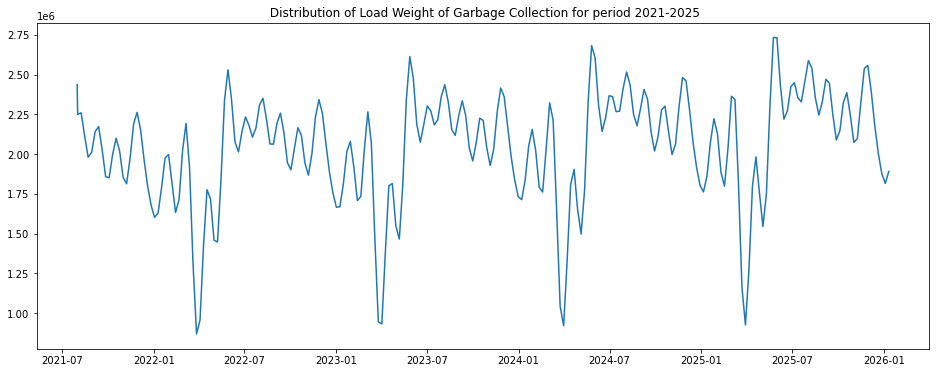

In [79]:
fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.plot(forecasted.index,forecasted['yhat'])
axes.set_title(" Distribution of Load Weight of Garbage Collection for period 2021-2025")
plt.show()

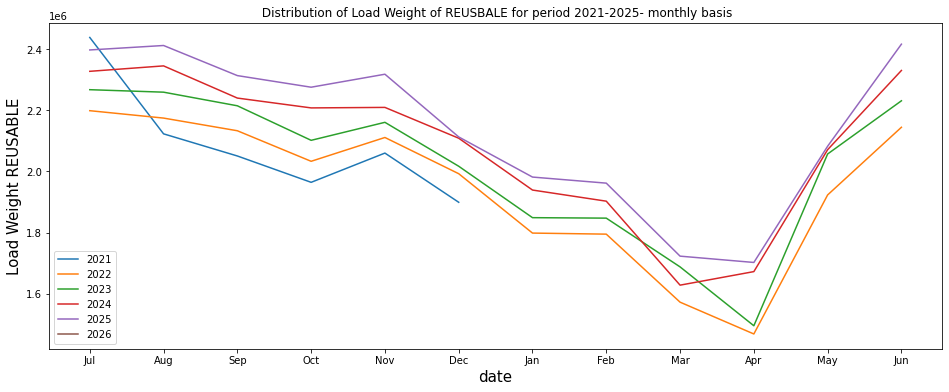

In [80]:
# Prepare data
df = reusable_forcasted_25.loc[:,['ds','yhat']]
df['year'] = [d.year for d in df['ds']]
df['month'] = [d.strftime('%b') for d in df['ds']]
years = df['year'].unique()

fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.set_xlabel('date', fontsize=15)
plt.set_loglevel('WARNING')

axes.set_ylabel('Load Weight REUSABLE', fontsize=15);
axes.set_title(" Distribution of Load Weight of REUSBALE for period 2021-2025- monthly basis")

        
for i,yr in enumerate(years):
    sns.lineplot(x=df.loc[df.year==yr, :]['month'],y=df.loc[df.year==yr, :]['yhat'],label=yr,ci=None);
    


Forcasted values of REUSABLE shows the upward trend from the period 2021 to 2025. The trend of REUSBALE throughout the year is varying,
- In April trends shows lowest Load Weight, which is 50% less than peak period of June-July.
- Overall we see the dcreasing trend in comparision to other load types.



## 🖼️ Visualisations


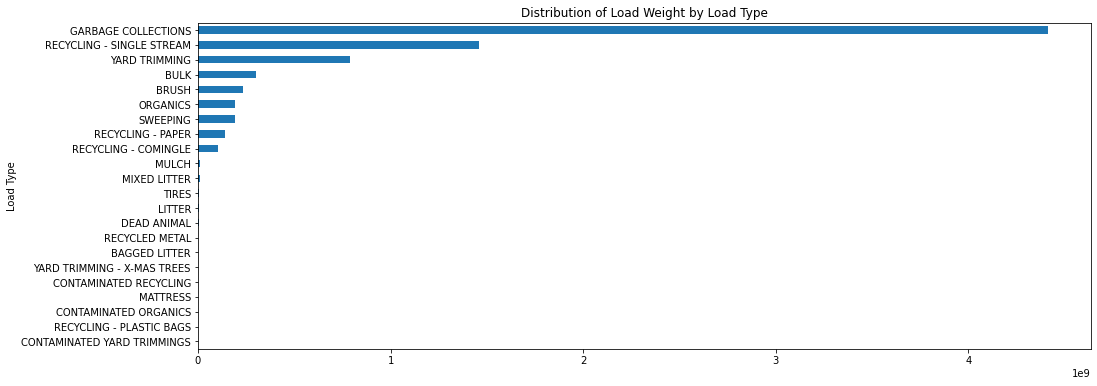

In [83]:
# Distribution of Load Weight in Load Type

plt.figure(figsize = (16,6))
dist = data.groupby('Load Type')['Load Weight'].sum().sort_values(ascending=True)
dist.plot(kind='barh');
plt.title('Distribution of Load Weight by Load Type');


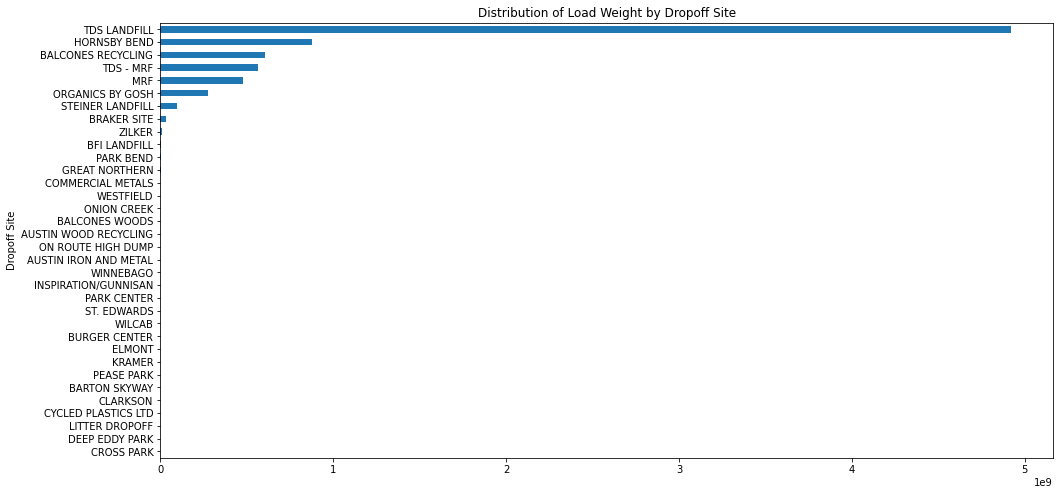

In [84]:
# Distribution of Load Weight in Dropoff Site

plt.figure(figsize = (16,8))
dist = data.groupby('Dropoff Site')['Load Weight'].sum().sort_values(ascending=True)
dist.plot(kind='barh');
plt.title('Distribution of Load Weight by Dropoff Site');


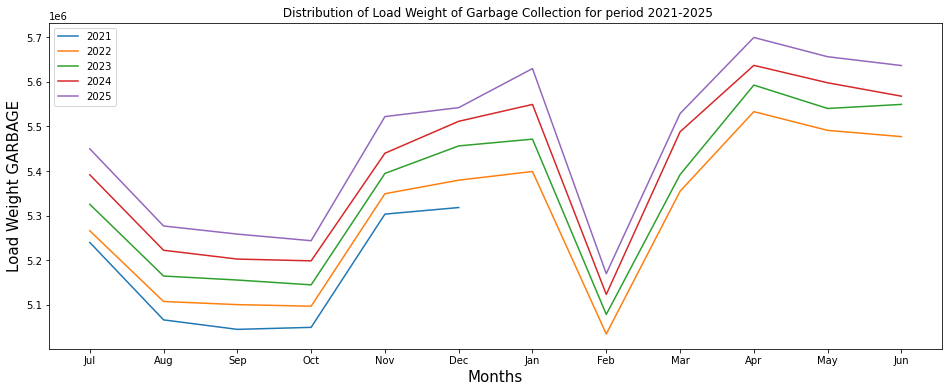

In [129]:
# Prepare data
df = garbage_forcasted_25.loc[:,['ds','yhat']]
df['year'] = [d.year for d in df['ds']]
df['month'] = [d.strftime('%b') for d in df['ds']]
years = df['year'].unique()

fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.set_xlabel('Months', fontsize=15)
plt.set_loglevel('WARNING')

axes.set_ylabel('Load Weight GARBAGE', fontsize=15);
axes.set_title(" Distribution of Load Weight of Garbage Collection for period 2021-2025")

        
for i,yr in enumerate(years):
    sns.lineplot(x=df.loc[df.year==yr, :]['month'],y=df.loc[df.year==yr, :]['yhat'],label=yr,ci=None);
    


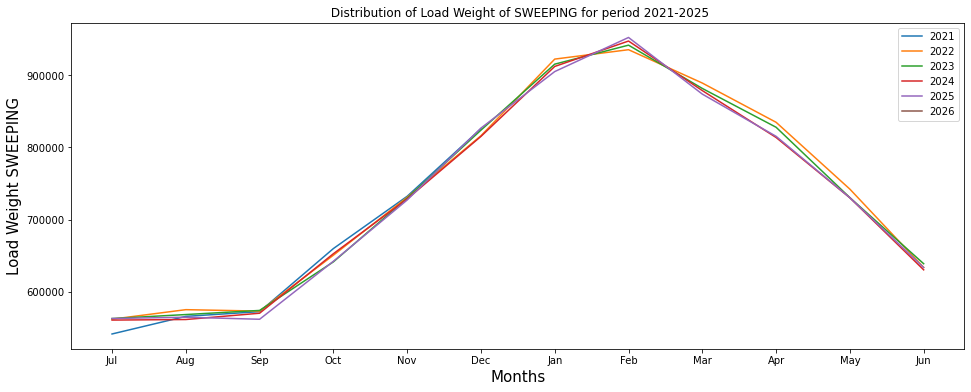

In [131]:
# Prepare data
df = sweeping_forcasted_25.loc[:,['ds','yhat']]
df['year'] = [d.year for d in df['ds']]
df['month'] = [d.strftime('%b') for d in df['ds']]
years = df['year'].unique()

fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.set_xlabel('Months', fontsize=15)
plt.set_loglevel('WARNING')

axes.set_ylabel('Load Weight SWEEPING', fontsize=15);
axes.set_title(" Distribution of Load Weight of SWEEPING for period 2021-2025")

        
for i,yr in enumerate(years):
    sns.lineplot(x=df.loc[df.year==yr, :]['month'],y=df.loc[df.year==yr, :]['yhat'],label=yr,ci=None);
    


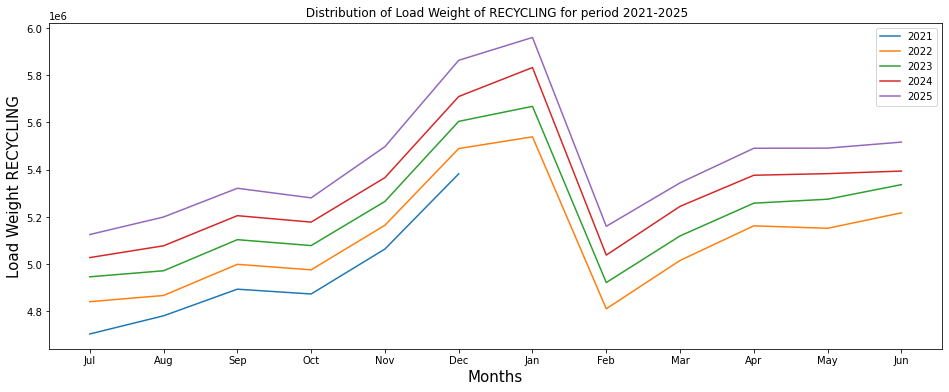

In [132]:
# Prepare data
df = recycling_forcasted_25.loc[:,['ds','yhat']]
df['year'] = [d.year for d in df['ds']]
df['month'] = [d.strftime('%b') for d in df['ds']]
years = df['year'].unique()

fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.set_xlabel('Months', fontsize=15)
plt.set_loglevel('WARNING')

axes.set_ylabel('Load Weight RECYCLING', fontsize=15);
axes.set_title(" Distribution of Load Weight of RECYCLING for period 2021-2025")

        
for i,yr in enumerate(years):
    sns.lineplot(x=df.loc[df.year==yr, :]['month'],y=df.loc[df.year==yr, :]['yhat'],label=yr,ci=None);
    


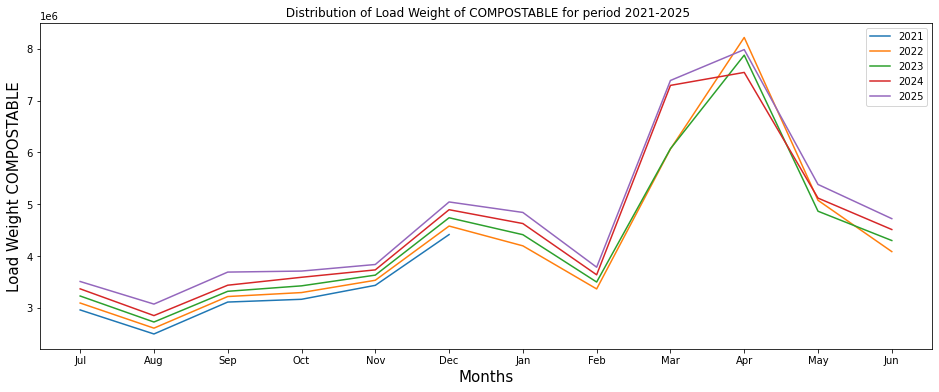

In [133]:
# Prepare data
df = compostable_forcasted_25.loc[:,['ds','yhat']]
df['year'] = [d.year for d in df['ds']]
df['month'] = [d.strftime('%b') for d in df['ds']]
years = df['year'].unique()

fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.set_xlabel('Months', fontsize=15)
plt.set_loglevel('WARNING')

axes.set_ylabel('Load Weight COMPOSTABLE', fontsize=15);
axes.set_title(" Distribution of Load Weight of COMPOSTABLE for period 2021-2025")

        
for i,yr in enumerate(years):
    sns.lineplot(x=df.loc[df.year==yr, :]['month'],y=df.loc[df.year==yr, :]['yhat'],label=yr,ci=None);
    


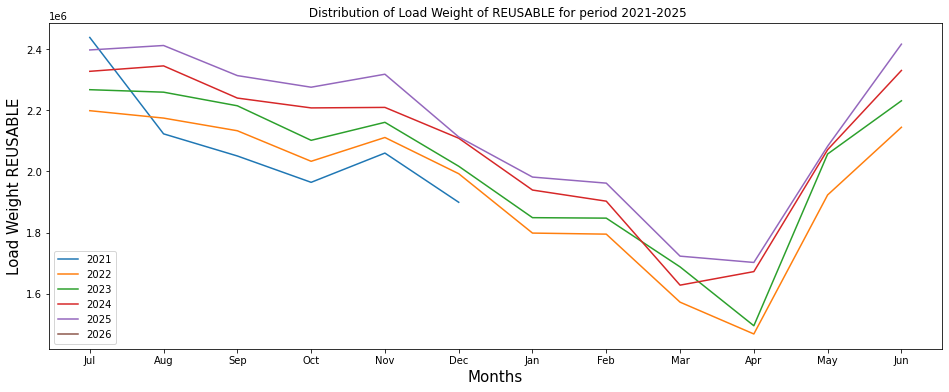

In [134]:
# Prepare data
df = reusable_forcasted_25.loc[:,['ds','yhat']]
df['year'] = [d.year for d in df['ds']]
df['month'] = [d.strftime('%b') for d in df['ds']]
years = df['year'].unique()

fig,axes = plt.subplots(1,1,figsize = (16,6))
axes.set_xlabel('Months', fontsize=15)
plt.set_loglevel('WARNING')

axes.set_ylabel('Load Weight REUSABLE', fontsize=15);
axes.set_title(" Distribution of Load Weight of REUSABLE for period 2021-2025")

        
for i,yr in enumerate(years):
    sns.lineplot(x=df.loc[df.year==yr, :]['month'],y=df.loc[df.year==yr, :]['yhat'],label=yr,ci=None);
    


## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

Dataset from Austin Texas : https://data.austintexas.gov/Utilities-and-City-Services/Waste-Collection-Diversion-Report-daily-/mbnu-4wq9

Sampling and Sorting Methodology - Garbage and Recyclables : https://www.austintexas.gov/sites/default/files/files/Resource_Recovery/Appendix_C_-_Limited_Sample_Sorting_Protocol.pdf

Zero Waste Case Study: Austin: https://www.epa.gov/transforming-waste-tool/zero-waste-case-study-austin

Mean absolute percentage error: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error